In [1]:
#Basic Tools
import os, sys, glob
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

#import logistic regression tools
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier


#import other classifier tools
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
plt.rcParams['figure.dpi'] = 800
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

#temp disable warnings
import warnings; warnings.simplefilter('ignore')

In [2]:
#Directory of radiomics results
classification_dir = "./Final_ResampledClassificationData.csv"
SelectedFeat_dir = "./results/LASSO_SelectedFeatures.csv"
report_dir = "./results/classification"

if not os.path.exists(report_dir):
    os.mkdir(report_dir)

In [3]:
#Set Data
classify_df = pd.read_csv(classification_dir)
features = pd.read_csv(SelectedFeat_dir)

#Get Features
ft = features["Feature"].values.tolist()
num_ft = len(ft)
print(num_ft)

ft = ["File", "unique_scandate","unique_pt","NE_Score", "NE_Status", "NE_Class", "Group"] + ft
print("\n")
print(ft)

20


['File', 'unique_scandate', 'unique_pt', 'NE_Score', 'NE_Status', 'NE_Class', 'Group', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterRow', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_SurfaceArea', 'original_shape_VoxelVolume', 'original_firstorder_Energy', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_gldm_DependenceNonUniformity', 'original_gldm_GrayLevelNonUniformity', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_LargeDependenceHighGrayLevelEmphasis', 'original_glrlm_GrayLevelNonUniformity', 'original_glrlm_RunLengthNonUniformity', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_LargeAreaEmphasis', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 'original_glszm_LargeAreaLowGrayLevelEmphasis', 'original_glszm_ZoneVariance']


In [4]:
feat_data = classify_df[ft]
#print(feat_data) 
#print(feat_data.columns[-num_ft:].values)

## Dataset Partition

In [5]:
#Get Group DataFrames
train_df = feat_data[feat_data["Group"] == "train"]
val_df = feat_data[feat_data["Group"] == "val"]
test_df = feat_data[feat_data["Group"] == "test"]
merge_train = feat_data[feat_data["Group"] != "test"]

In [6]:
#Get Test Set variables 
X_test = test_df[test_df.columns[-num_ft:].values]
Y_test = test_df[test_df.columns[5]]
Y_files = test_df["File"].tolist()
Y_scans = test_df["unique_scandate"].tolist()
Y_pts = test_df["unique_pt"].tolist()

#Get Train and Val variables 
X_merge = merge_train[merge_train.columns[-num_ft:].values]
Y_merge = merge_train[merge_train.columns[5]]

# print(X_merge)
# print(Y_merge)

In [7]:
#Create 5-fold CV based merged data
cv = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 2024)

In [8]:
print(cv.get_n_splits(X_merge))
trainfold_dict = {"Fold0":[], "Fold1":[], "Fold2":[], "Fold3":[], "Fold4":[]}
testfold_dict = {"Fold0":[], "Fold1":[], "Fold2":[], "Fold3":[], "Fold4":[]}

for i, (train_index, test_index) in enumerate(cv.split(X_merge)):
    print(f"\nFold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
    trainfold_dict["Fold"+str(i)].append(train_index.tolist())
    testfold_dict["Fold"+str(i)].append(test_index.tolist())

5

Fold 0:
  Train: index=[149  83  17  44 168  72 100 109 167  25  49 105  76   4   5  14 162  85
  52  35  37  79  75   0 154 121 137  19 141  10  23  99  16  98 115 151
 122  71   6  32 101 159   9  81 155  51 147 146  84  47 124 152  67   3
  58 133 125 120  93  20  87   2  13  59  62 166 118 160  50   7 163  12
  64 116  53  33   1 123  65 107  45 169 104 143 130  29  77   8 103  63
 129 161  48 153  22  43 174 175  94  90 150  18 176 126 144 148  57 132
 156  61  69 119  86 173  97  31  42 102  73 114  54  39  91  28  11 164
  95 110 111 158 165  66  74  60 127  41  36  27 128  96 136]
  Test:  index=[171  46 142  55  40 112 134  92 145  70  78  68  89  15 117 108  34 140
  21 131  38 170  80 113  88 157 138  30 172 106  82  56  26 135  24 139]

Fold 1:
  Train: index=[118  27  68 131 126  58  42  54  85 130  24 152  33 123  16  15 115   6
 142 168  99  20   4  47  98  76 139  40  66  26   0   9  94  60  14 116
 120  88  86   2 104  51  10  11 110  65 107  28 103  92  30 174 158 

In [9]:
trainfold_df = pd.DataFrame(trainfold_dict)
testfold_df = pd.DataFrame(testfold_dict)

#save csv 
merge_train.to_csv(os.path.join(report_dir, "FinalTrainValSet.csv"), index_label = "Index")
trainfold_df.to_csv(os.path.join(report_dir, "FinalTrainFoldIndices.csv"), index = False)
testfold_df.to_csv(os.path.join(report_dir, "FinalTestFoldIndices.csv"), index = False)

# UNWEIGHTED TRAINING

## Logistic Classifier

In [10]:
clf_log = LogisticRegression(random_state=2024, C = 3, solver = 'newton-cg',  max_iter = 10000)
cv_results = cross_validate(clf_log, X_merge, Y_merge, cv = cv, scoring = ('f1','roc_auc'), return_estimator = True, return_train_score = True)

In [11]:
print(cv_results.keys())
print("\nTraining F1 Scores: ")
print(cv_results["train_f1"],cv_results["train_roc_auc"])
print("\nValidation F1 Scores: ")
print(cv_results["test_f1"],cv_results["test_roc_auc"])

dict_keys(['fit_time', 'score_time', 'estimator', 'test_f1', 'train_f1', 'test_roc_auc', 'train_roc_auc'])

Training F1 Scores: 
[0.88702929 0.89451477 0.88135593 0.88065844 0.88065844] [0.80731171 0.80703683 0.7983368  0.74102132 0.78058361]

Validation F1 Scores: 
[0.87096774 0.83333333 0.89230769 0.83333333 0.81355932] [0.62962963 0.4691358  0.45       0.66538462 0.53846154]


In [12]:
my_folds = ["Fold" + str(x) for x in list(range(1,6))]
train_val_df = pd.DataFrame({"Fold":my_folds, "Train_F1Score":cv_results["train_f1"].tolist(), "Val_F1Score": cv_results["test_f1"].tolist(), "Train_AUCScore":cv_results["train_roc_auc"].tolist(), "Val_AUCScore": cv_results["test_roc_auc"].tolist()})
print(train_val_df)
train_val_df.to_csv(os.path.join(report_dir, "Unweighted_LogisticRegression_CVTraining.csv"), index = False)

    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.887029     0.870968        0.807312      0.629630
1  Fold2       0.894515     0.833333        0.807037      0.469136
2  Fold3       0.881356     0.892308        0.798337      0.450000
3  Fold4       0.880658     0.833333        0.741021      0.665385
4  Fold5       0.880658     0.813559        0.780584      0.538462


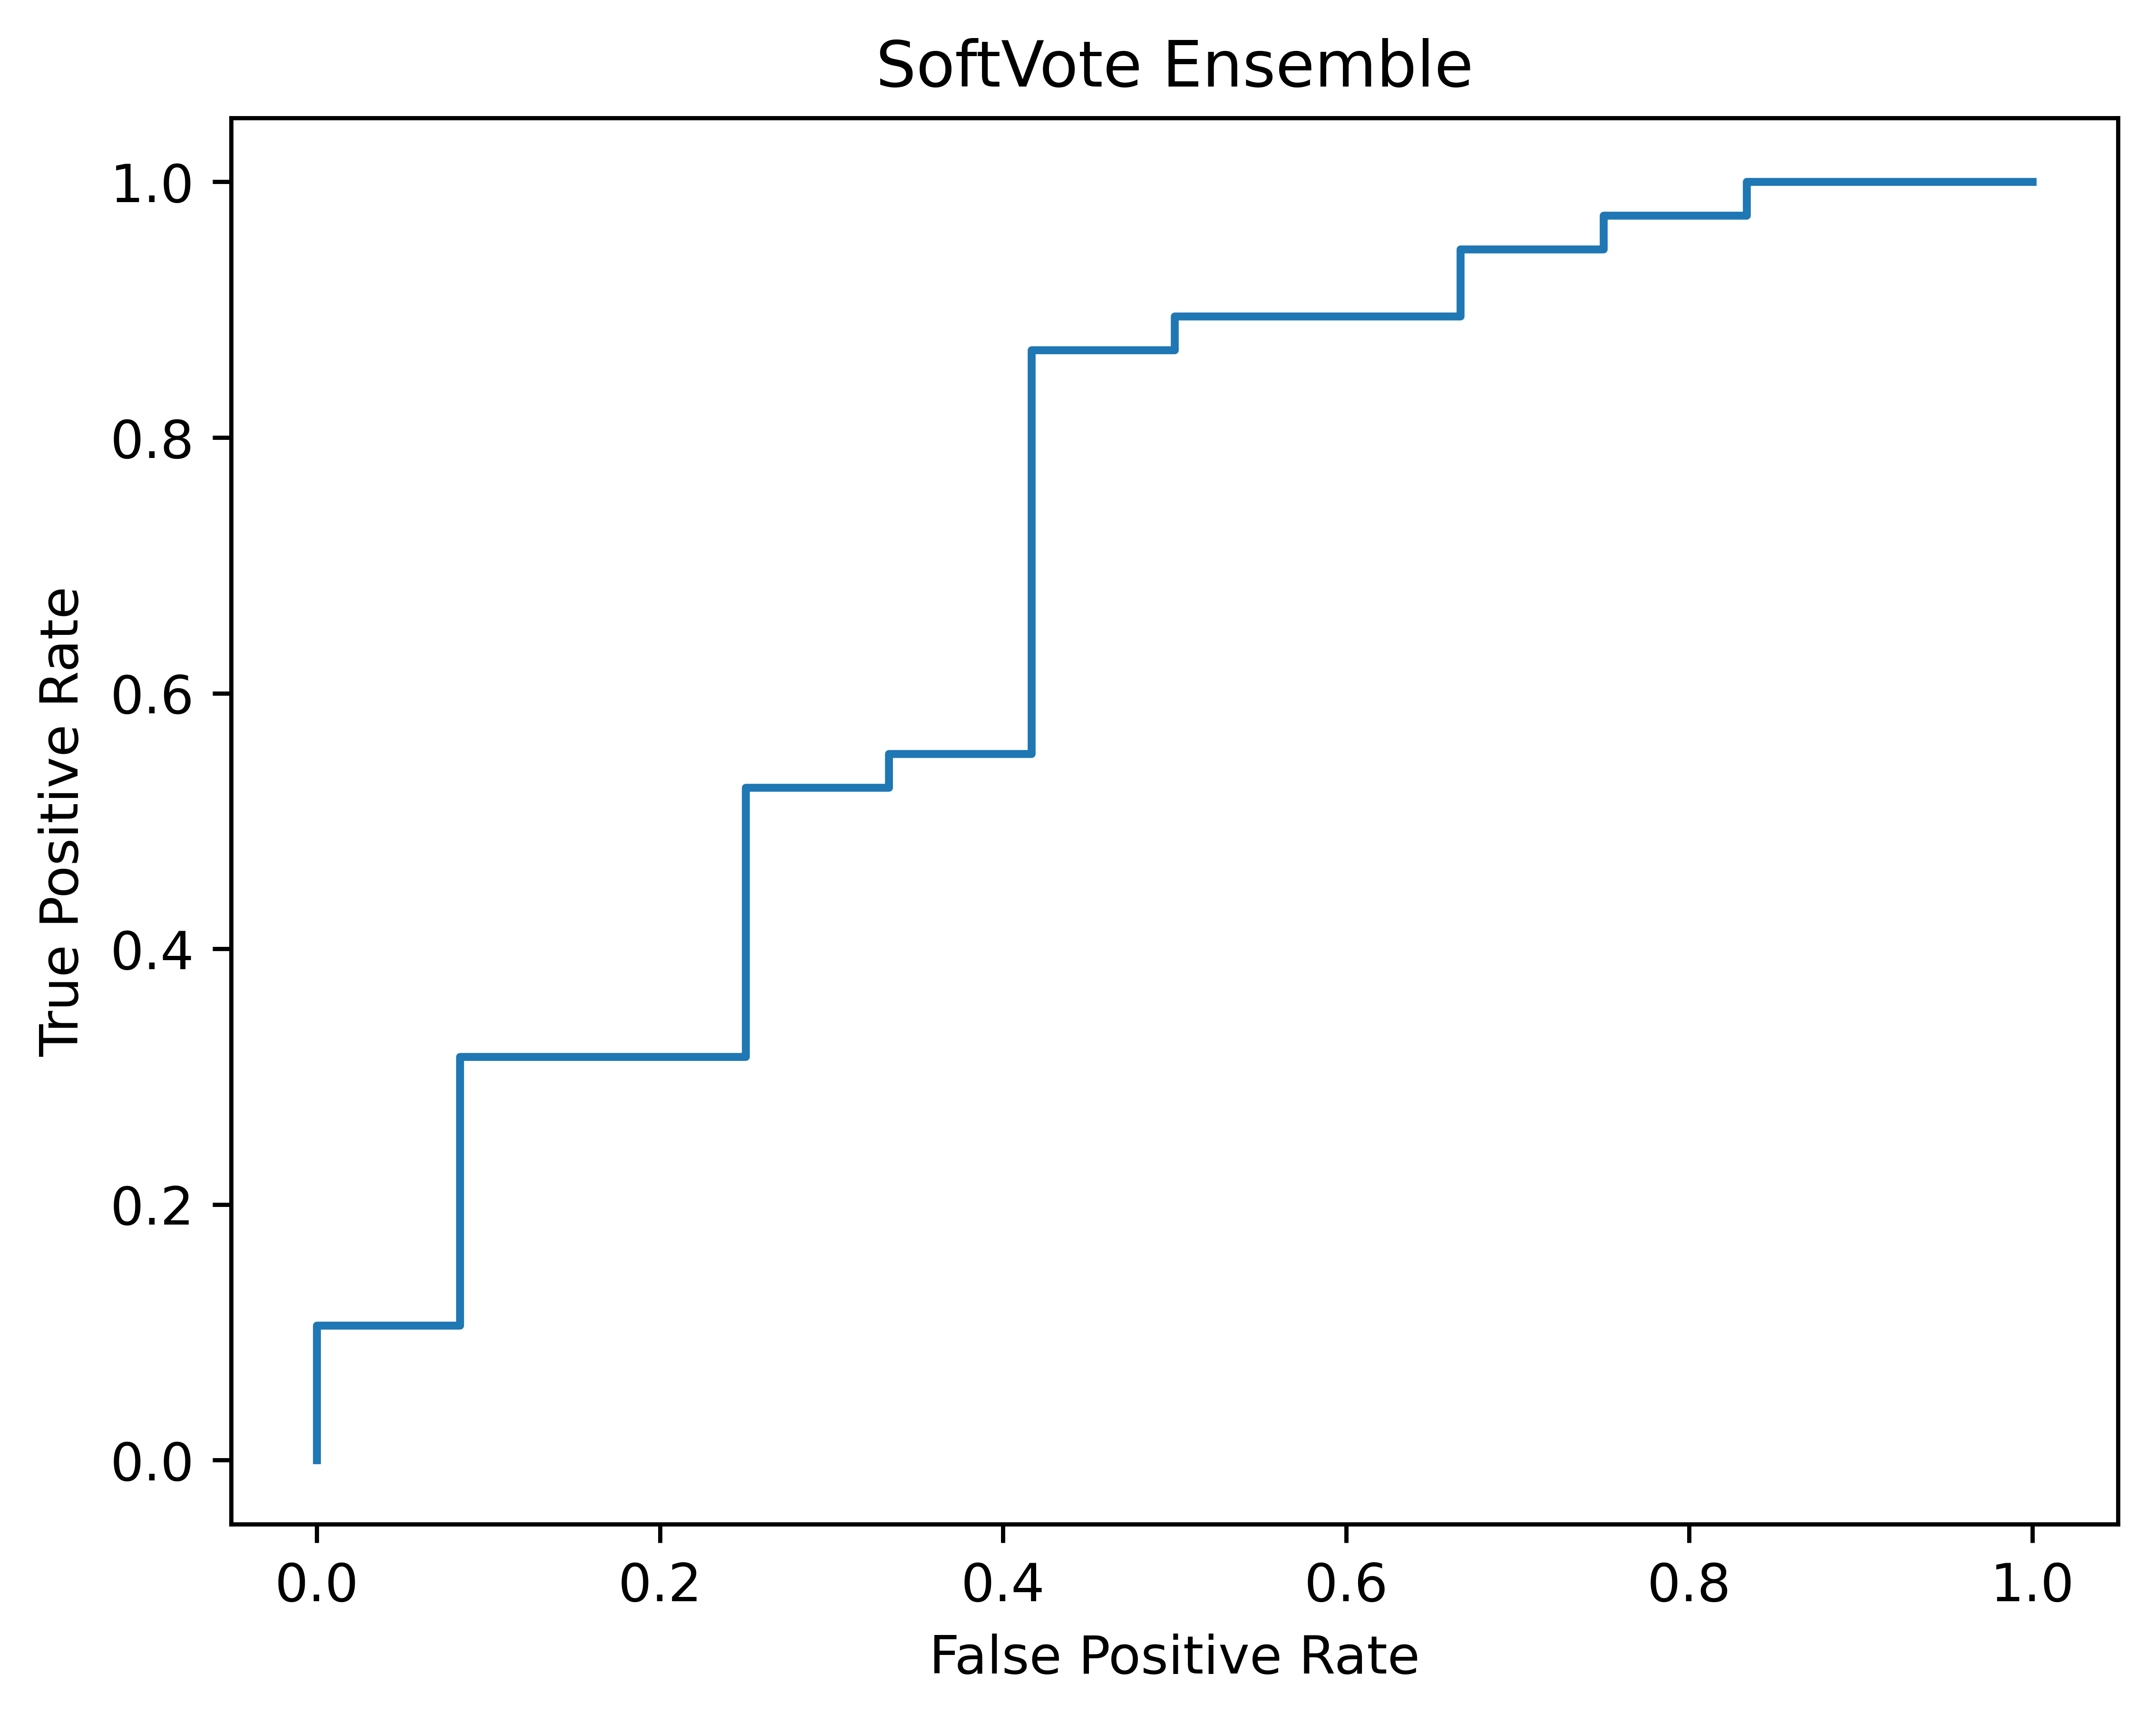

In [13]:
#Get each classifier 
clf1 = cv_results["estimator"][0]
clf2 = cv_results["estimator"][1]
clf3 = cv_results["estimator"][2]
clf4 = cv_results["estimator"][3]
clf5 = cv_results["estimator"][4]

#get ensemble methods
hard_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='hard')
hard_vote_ens.fit(X_merge, Y_merge)
soft_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='soft')
soft_vote_ens.fit(X_merge, Y_merge)

#Get metrics
test_metrics_dict = {"Model":[], "Accuracy":[], "PPV":[], "Sensitivity":[], "NPV":[], "Specificity":[], "FPR":[], "F1_Score":[], "ConfusionMatrix":[], 
                     "YPred_Prob":[], "AUC":[], "ROC_TPR":[], "ROC_FPR":[], "ROC_Threshold":[]}

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, hard_vote_ens, soft_vote_ens], ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "HardVote_Ensemble", "SoftVote_Ensemble"]):
    ypred = clf.predict(X_test)
    
    #calculate metrics  
    acc = accuracy_score(Y_test, ypred)
    ppv = precision_score(Y_test, ypred)
    CM = confusion_matrix(Y_test, ypred)
    f1 = f1_score(Y_test, ypred)
    sens = recall_score(Y_test, ypred)
    tn, fp, fn, tp = confusion_matrix(Y_test, ypred).ravel()
    spec = tn / (tn+fp)
    FPR = fp/(fp+tn)
    npv = tn/(tn + fn)
    
    #append
    test_metrics_dict["Model"].append(label)
    test_metrics_dict["Accuracy"].append(acc)
    test_metrics_dict["PPV"].append(ppv)
    test_metrics_dict["Sensitivity"].append(sens)
    test_metrics_dict["Specificity"].append(spec)
    test_metrics_dict["FPR"].append(FPR)
    test_metrics_dict["F1_Score"].append(f1)
    test_metrics_dict["ConfusionMatrix"].append(CM)
    test_metrics_dict["NPV"].append(npv)
    
    #ROC AUC analysis
    if "HardVote" not in label: 
        ypred_prob = clf.predict_proba(X_test)[:,1]
        auc = roc_auc_score(Y_test, ypred_prob)
        roc_fpr, roc_tpr, thresholds = roc_curve(Y_test, ypred_prob)
    else: 
        ypred_prob = np.nan
        auc = np.nan
        roc_fpr = roc_tpr = thresholds = np.nan
    
    #append AUC ROC metrics 
    test_metrics_dict["AUC"].append(auc)
    test_metrics_dict["YPred_Prob"].append(ypred_prob)
    test_metrics_dict["ROC_TPR"].append(roc_tpr)
    test_metrics_dict["ROC_FPR"].append(roc_fpr)
    test_metrics_dict["ROC_Threshold"].append(thresholds)
    
    #plot ROC
    if "SoftVote" in label: 
        plt.plot(roc_fpr, roc_tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(label.replace("_", " "))
        plt.show()

    #prediction dictionary for bootstrap statistical analysis later
    bootstrap_metrics_dict = {"File":[], "unique_scandate":[], "unique_pt":[], "gt":[], "pred_bin":[], "pred_contin":[]}
    for _i in range(0,len(ypred)):
        bootstrap_metrics_dict["File"].append(Y_files[_i])
        bootstrap_metrics_dict["unique_scandate"].append(Y_scans[_i])
        bootstrap_metrics_dict["unique_pt"].append(Y_pts[_i])
        bootstrap_metrics_dict["gt"].append(Y_test.tolist()[_i])
        bootstrap_metrics_dict["pred_bin"].append(ypred[_i])
        if "HardVote" not in label:
            bootstrap_metrics_dict["pred_contin"].append(ypred_prob[_i])
        else:
            bootstrap_metrics_dict["pred_contin"].append(np.nan)
    b_df = pd.DataFrame(bootstrap_metrics_dict)
    b_df.to_csv(os.path.join(report_dir, "Unweighted_LogisticRegression_"+label+"_predictions_test.csv"), index = False)

In [14]:
log_df = pd.DataFrame(test_metrics_dict)
#print(log_df)
log_df.to_csv(os.path.join(report_dir, "Unweighted_LogisticRegression_CVresults.csv"), index = False)

## Random Forest

In [15]:
rfc = RandomForestClassifier(n_estimators = 1000, random_state=200, criterion = "gini", min_samples_leaf = 2)
cv_results = cross_validate(rfc, X_merge, Y_merge, cv = cv, scoring = ('f1','roc_auc'), return_estimator = True, return_train_score = True)

In [16]:
print(cv_results.keys())
print("\nTraining F1 Scores: ")
print(cv_results["train_f1"],cv_results["train_roc_auc"])
print("\nValidation F1 Scores: ")
print(cv_results["test_f1"],cv_results["test_roc_auc"])

dict_keys(['fit_time', 'score_time', 'estimator', 'test_f1', 'train_f1', 'test_roc_auc', 'train_roc_auc'])

Training F1 Scores: 
[1.         0.99074074 1.         0.99539171 0.98630137] [1.         1.         1.         1.         0.99915825]

Validation F1 Scores: 
[0.87096774 0.86666667 0.90625    0.81355932 0.82142857] [0.81069959 0.55555556 0.62222222 0.74230769 0.65      ]


In [17]:
my_folds = ["Fold" + str(x) for x in list(range(1,6))]
train_val_df = pd.DataFrame({"Fold":my_folds, "Train_F1Score":cv_results["train_f1"].tolist(), "Val_F1Score": cv_results["test_f1"].tolist(), "Train_AUCScore":cv_results["train_roc_auc"].tolist(), "Val_AUCScore": cv_results["test_roc_auc"].tolist()})
print(train_val_df)
train_val_df.to_csv(os.path.join(report_dir, "Unweighted_RandomForest_CVTraining.csv"), index = False)

    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       1.000000     0.870968        1.000000      0.810700
1  Fold2       0.990741     0.866667        1.000000      0.555556
2  Fold3       1.000000     0.906250        1.000000      0.622222
3  Fold4       0.995392     0.813559        1.000000      0.742308
4  Fold5       0.986301     0.821429        0.999158      0.650000


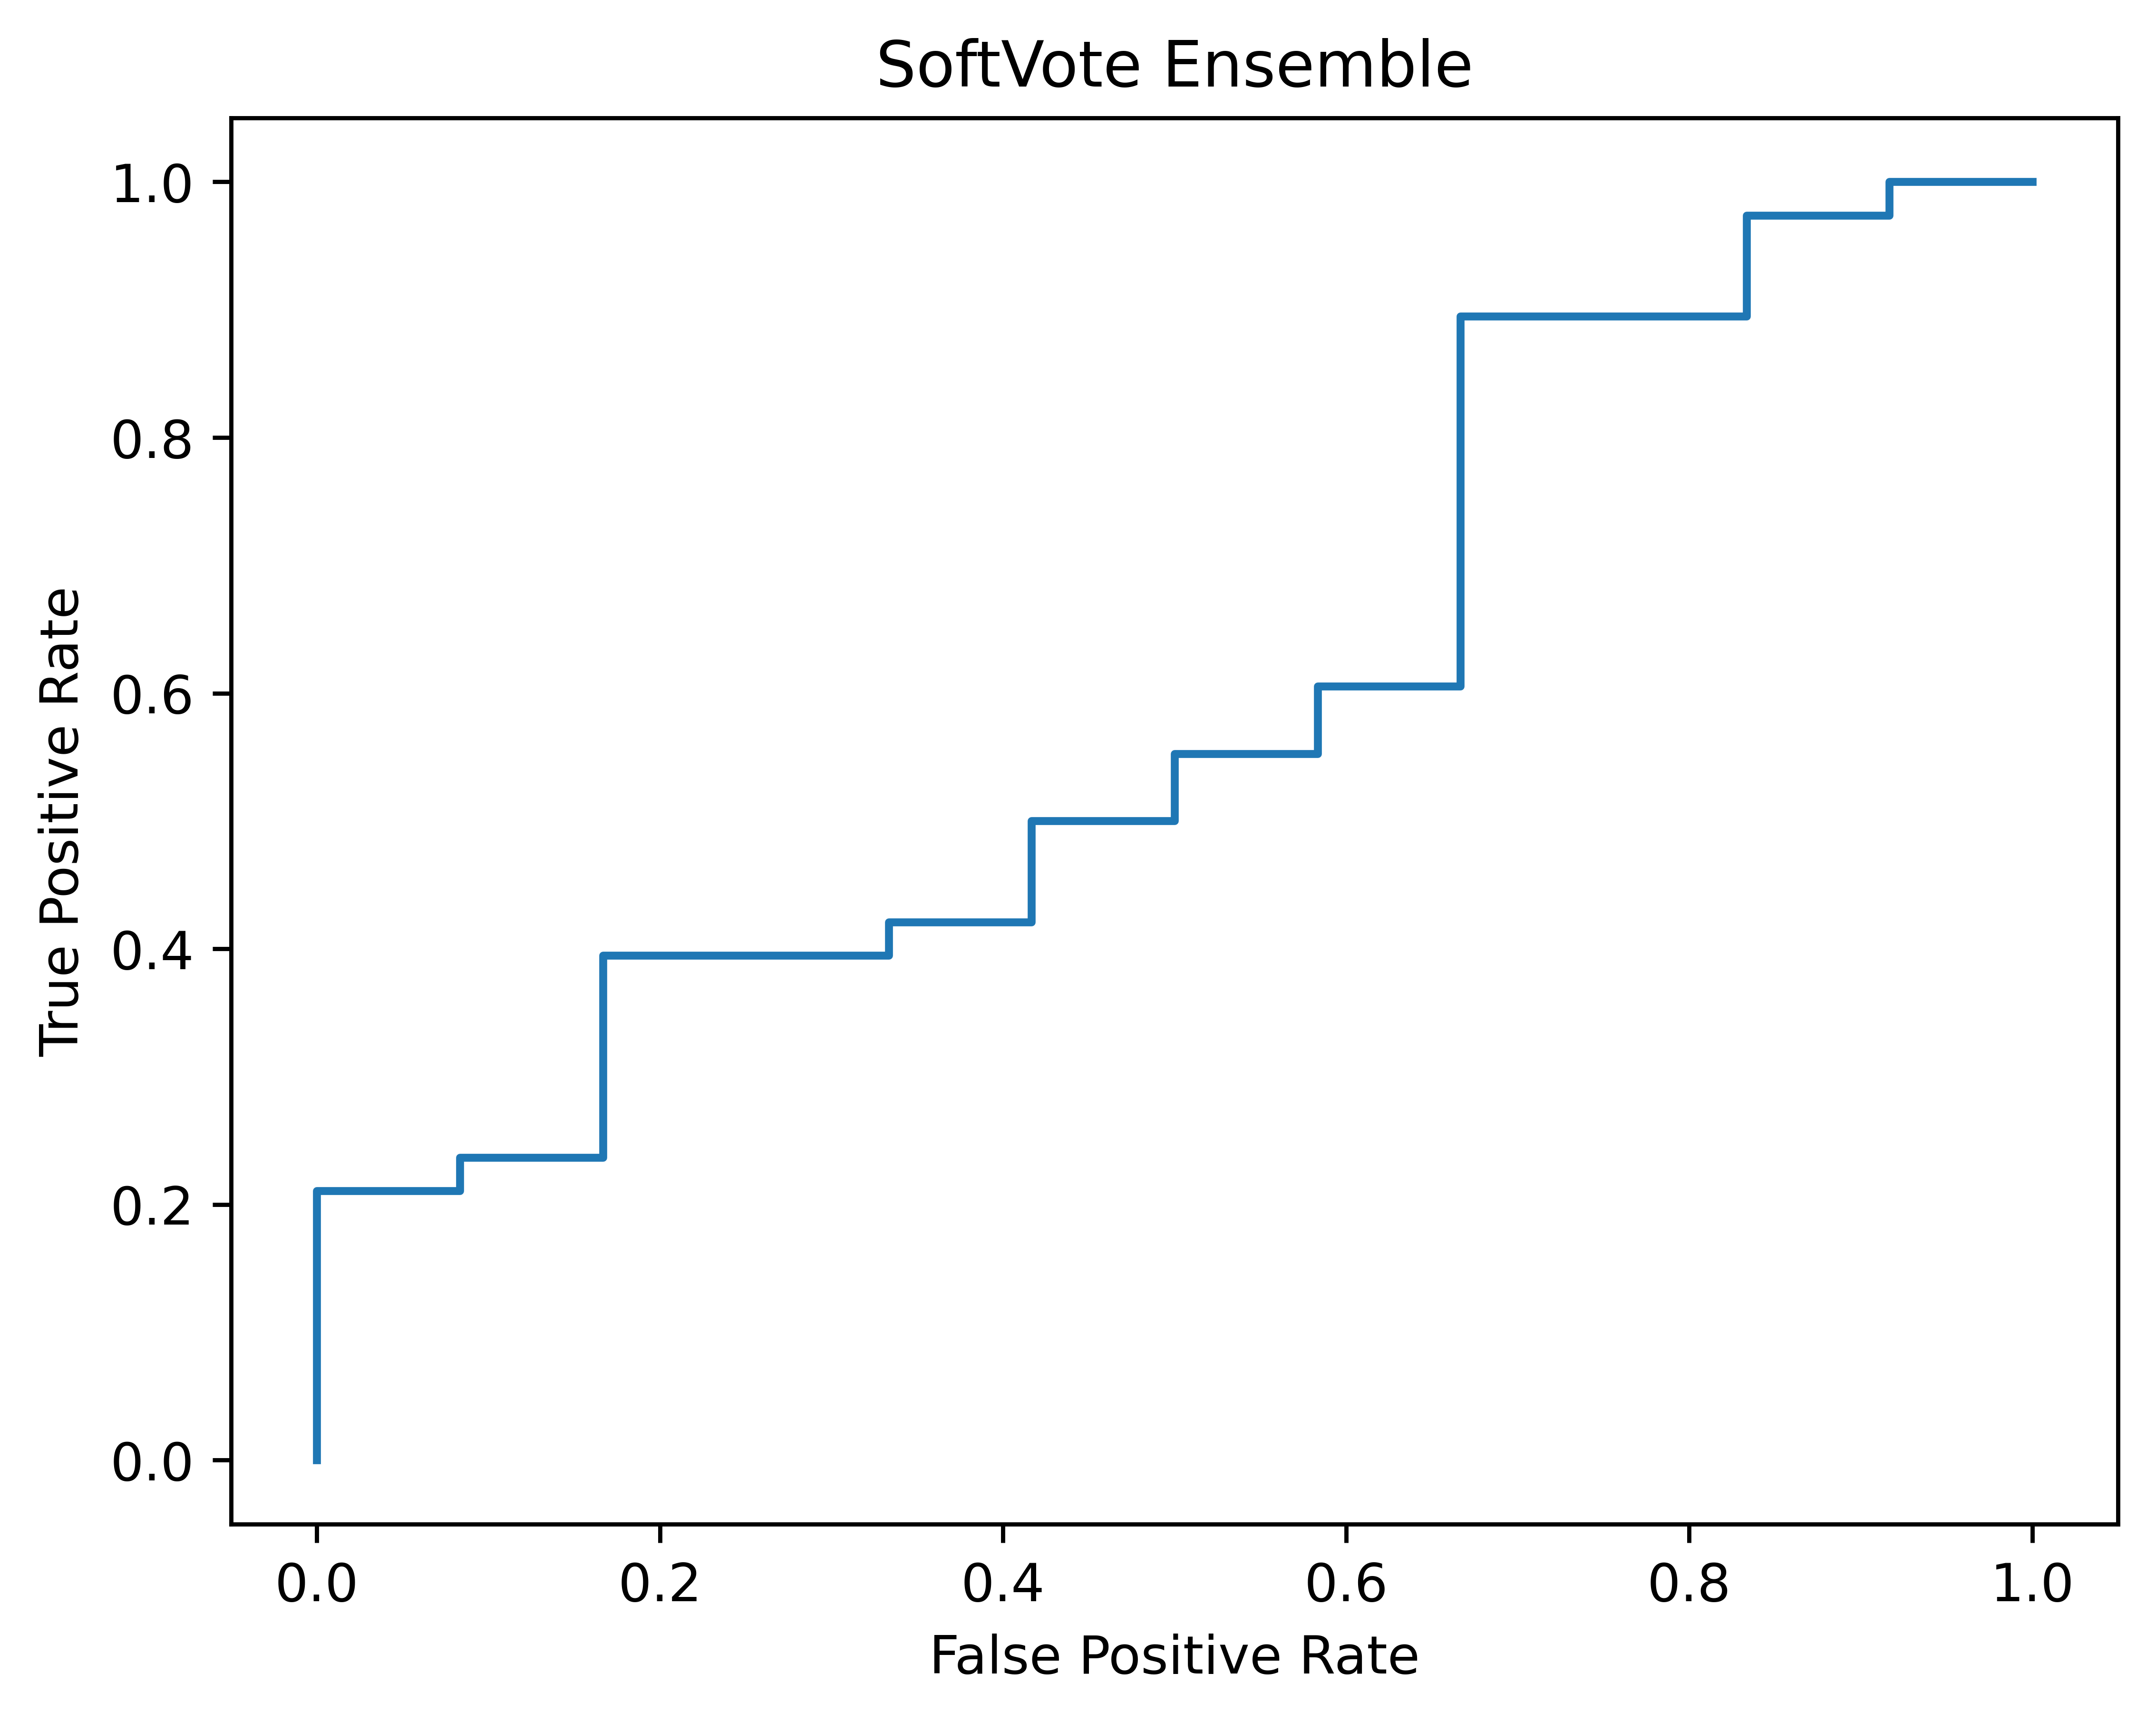

In [18]:
#Get each classifier 
clf1 = cv_results["estimator"][0]
clf2 = cv_results["estimator"][1]
clf3 = cv_results["estimator"][2]
clf4 = cv_results["estimator"][3]
clf5 = cv_results["estimator"][4]

#get ensemble methods
hard_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='hard')
hard_vote_ens.fit(X_merge, Y_merge)
soft_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='soft')
soft_vote_ens.fit(X_merge, Y_merge)

#Get metrics
test_metrics_dict = {"Model":[], "Accuracy":[], "PPV":[], "Sensitivity":[], "NPV":[], "Specificity":[], "FPR":[], "F1_Score":[], "ConfusionMatrix":[], 
                     "YPred_Prob":[], "AUC":[], "ROC_TPR":[], "ROC_FPR":[], "ROC_Threshold":[]}

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, hard_vote_ens, soft_vote_ens], ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "HardVote_Ensemble", "SoftVote_Ensemble"]):
    ypred = clf.predict(X_test)
    
    #calculate metrics  
    acc = accuracy_score(Y_test, ypred)
    ppv = precision_score(Y_test, ypred)
    CM = confusion_matrix(Y_test, ypred)
    f1 = f1_score(Y_test, ypred)
    sens = recall_score(Y_test, ypred)
    tn, fp, fn, tp = confusion_matrix(Y_test, ypred).ravel()
    spec = tn / (tn+fp)
    FPR = fp/(fp+tn)
    npv = tn/(tn+fn)
    
    #append
    test_metrics_dict["Model"].append(label)
    test_metrics_dict["Accuracy"].append(acc)
    test_metrics_dict["PPV"].append(ppv)
    test_metrics_dict["Sensitivity"].append(sens)
    test_metrics_dict["Specificity"].append(spec)
    test_metrics_dict["FPR"].append(FPR)
    test_metrics_dict["F1_Score"].append(f1)
    test_metrics_dict["ConfusionMatrix"].append(CM)
    test_metrics_dict["NPV"].append(npv)
    
    #ROC AUC analysis
    if "HardVote" not in label: 
        ypred_prob = clf.predict_proba(X_test)[:,1]
        auc = roc_auc_score(Y_test, ypred_prob)
        roc_fpr, roc_tpr, thresholds = roc_curve(Y_test, ypred_prob)
    else: 
        ypred_prob = np.nan
        auc = np.nan
        roc_fpr = roc_tpr = thresholds = np.nan
    
    #append AUC ROC metrics 
    test_metrics_dict["AUC"].append(auc)
    test_metrics_dict["YPred_Prob"].append(ypred_prob)
    test_metrics_dict["ROC_TPR"].append(roc_tpr)
    test_metrics_dict["ROC_FPR"].append(roc_fpr)
    test_metrics_dict["ROC_Threshold"].append(thresholds)
    
    #plot ROC
    if "SoftVote" in label: 
        plt.plot(roc_fpr, roc_tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(label.replace("_", " "))
        plt.show()

    #prediction dictionary for bootstrap statistical analysis later
    bootstrap_metrics_dict = {"File":[], "unique_scandate":[], "unique_pt":[], "gt":[], "pred_bin":[], "pred_contin":[]}
    for _i in range(0,len(ypred)):
        bootstrap_metrics_dict["File"].append(Y_files[_i])
        bootstrap_metrics_dict["unique_scandate"].append(Y_scans[_i])
        bootstrap_metrics_dict["unique_pt"].append(Y_pts[_i])
        bootstrap_metrics_dict["gt"].append(Y_test.tolist()[_i])
        bootstrap_metrics_dict["pred_bin"].append(ypred[_i])
        if "HardVote" not in label:
            bootstrap_metrics_dict["pred_contin"].append(ypred_prob[_i])
        else:
            bootstrap_metrics_dict["pred_contin"].append(np.nan)
    b_df = pd.DataFrame(bootstrap_metrics_dict)
    b_df.to_csv(os.path.join(report_dir, "Unweighted_RandomForest_"+label+"_predictions_test.csv"), index = False)
    


In [19]:
rfc_df = pd.DataFrame(test_metrics_dict)
#print(rfc_df)
rfc_df.to_csv(os.path.join(report_dir, "Unweighted_RandomForest_CVresults.csv"), index = False)

## XGBoost 

In [20]:
xgbm = xgb.XGBClassifier(tree_method="hist", seed = 100, booster = 'gblinear')
cv_results = cross_validate(xgbm, X_merge, Y_merge, cv = cv, scoring = ('f1','roc_auc'), return_estimator = True, return_train_score = True)

In [21]:
print(cv_results.keys())
print("\nTraining F1 Scores: ")
print(cv_results["train_f1"],cv_results["train_roc_auc"])
print("\nValidation F1 Scores: ")
print(cv_results["test_f1"],cv_results["test_roc_auc"])

dict_keys(['fit_time', 'score_time', 'estimator', 'test_f1', 'train_f1', 'test_roc_auc', 'train_roc_auc'])

Training F1 Scores: 
[0.88702929 0.88510638 0.86956522 0.88702929 0.88235294] [0.76663002 0.78477185 0.81055094 0.77441077 0.78367003]

Validation F1 Scores: 
[0.86666667 0.83333333 0.90625    0.82758621 0.80701754] [0.63786008 0.48148148 0.47777778 0.68846154 0.62307692]


In [22]:
my_folds = ["Fold" + str(x) for x in list(range(1,6))]
train_val_df = pd.DataFrame({"Fold":my_folds, "Train_F1Score":cv_results["train_f1"].tolist(), "Val_F1Score": cv_results["test_f1"].tolist(), "Train_AUCScore":cv_results["train_roc_auc"].tolist(), "Val_AUCScore": cv_results["test_roc_auc"].tolist()})
print(train_val_df)
train_val_df.to_csv(os.path.join(report_dir, "Unweighted_XGBoost_CVTraining.csv"), index = False)

    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.887029     0.866667        0.766630      0.637860
1  Fold2       0.885106     0.833333        0.784772      0.481481
2  Fold3       0.869565     0.906250        0.810551      0.477778
3  Fold4       0.887029     0.827586        0.774411      0.688462
4  Fold5       0.882353     0.807018        0.783670      0.623077


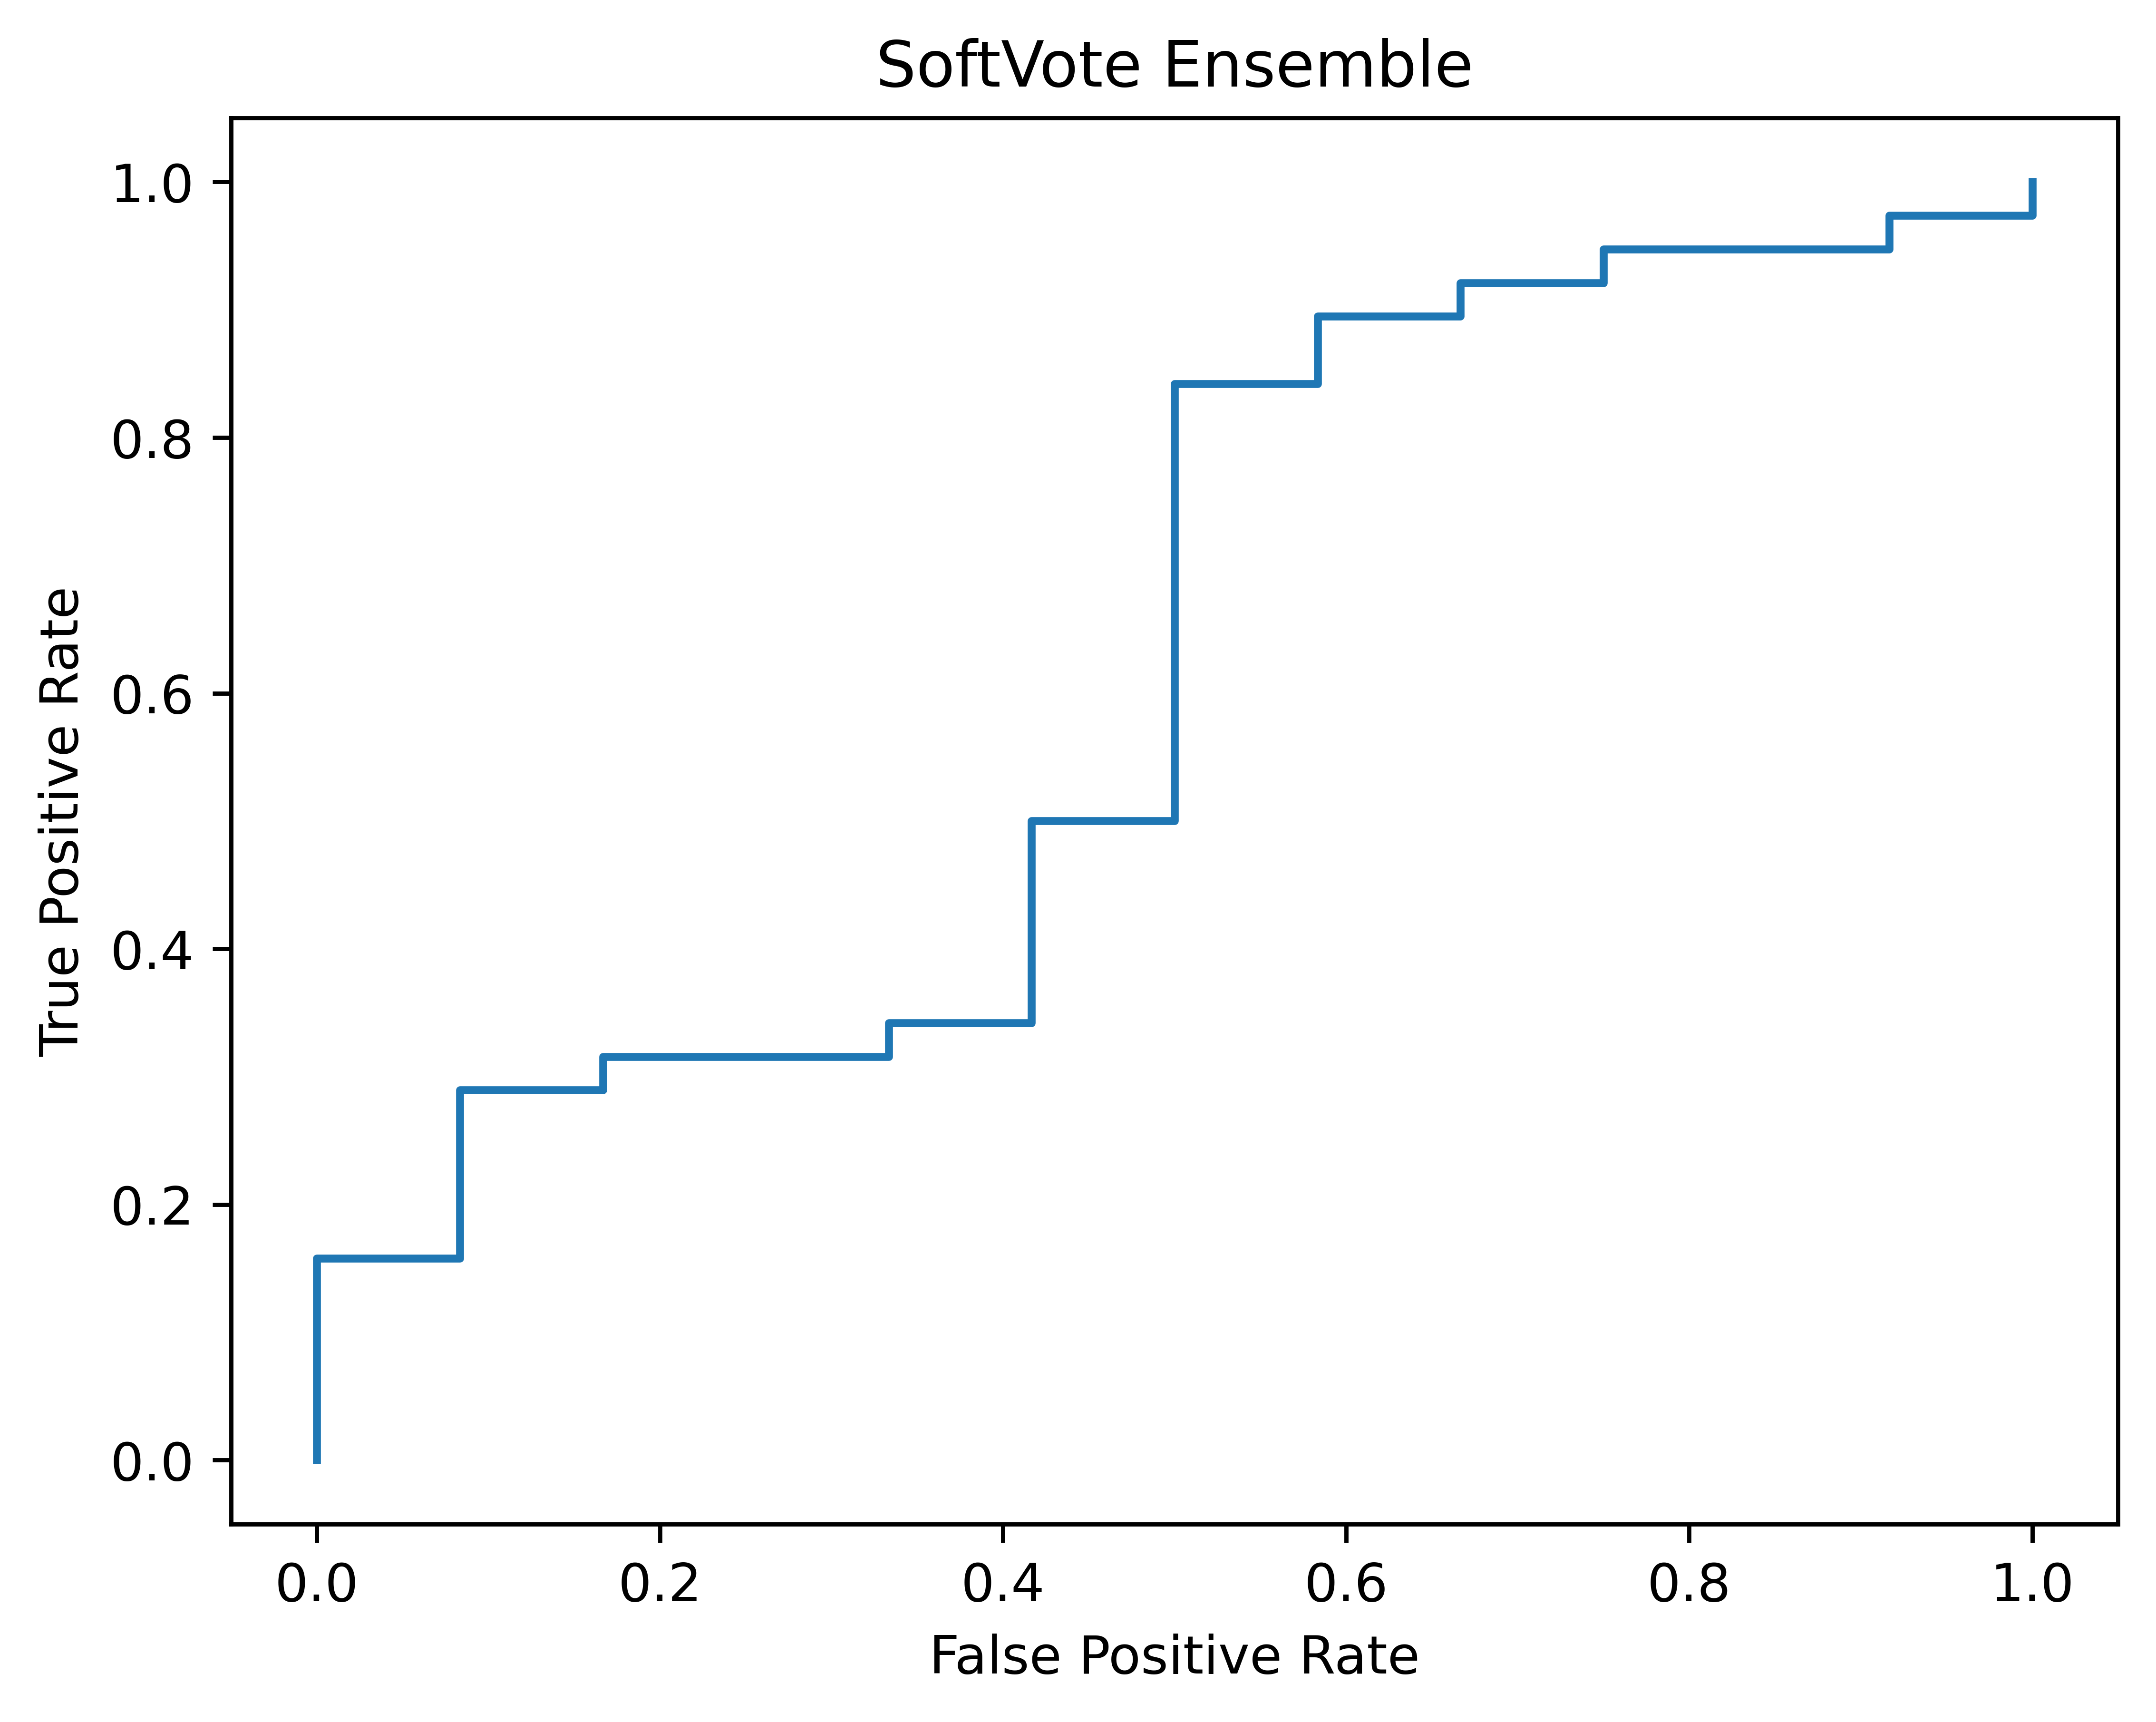

In [23]:
#Get each classifier 
clf1 = cv_results["estimator"][0]
clf2 = cv_results["estimator"][1]
clf3 = cv_results["estimator"][2]
clf4 = cv_results["estimator"][3]
clf5 = cv_results["estimator"][4]

#get ensemble methods
hard_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='hard')
hard_vote_ens.fit(X_merge, Y_merge)
soft_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='soft')
soft_vote_ens.fit(X_merge, Y_merge)

#Get metrics
test_metrics_dict = {"Model":[], "Accuracy":[], "PPV":[], "Sensitivity":[], "NPV":[], "Specificity":[], "FPR":[], "F1_Score":[], "ConfusionMatrix":[], 
                     "YPred_Prob":[], "AUC":[], "ROC_TPR":[], "ROC_FPR":[], "ROC_Threshold":[]}


for clf, label in zip([clf1, clf2, clf3, clf4, clf5, hard_vote_ens, soft_vote_ens], ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "HardVote_Ensemble", "SoftVote_Ensemble"]):
    ypred = clf.predict(X_test)
    
    #calculate metrics  
    acc = accuracy_score(Y_test, ypred)
    ppv = precision_score(Y_test, ypred)
    CM = confusion_matrix(Y_test, ypred)
    f1 = f1_score(Y_test, ypred)
    sens = recall_score(Y_test, ypred)
    tn, fp, fn, tp = confusion_matrix(Y_test, ypred).ravel()
    spec = tn / (tn+fp)
    FPR = fp/(fp+tn)
    npv = tn/(tn+fn)
    
    #append
    test_metrics_dict["Model"].append(label)
    test_metrics_dict["Accuracy"].append(acc)
    test_metrics_dict["PPV"].append(ppv)
    test_metrics_dict["Sensitivity"].append(sens)
    test_metrics_dict["Specificity"].append(spec)
    test_metrics_dict["FPR"].append(FPR)
    test_metrics_dict["F1_Score"].append(f1)
    test_metrics_dict["ConfusionMatrix"].append(CM)
    test_metrics_dict["NPV"].append(npv)
    
    #ROC AUC analysis
    if "HardVote" not in label: 
        ypred_prob = clf.predict_proba(X_test)[:,1]
        auc = roc_auc_score(Y_test, ypred_prob)
        roc_fpr, roc_tpr, thresholds = roc_curve(Y_test, ypred_prob)
    else: 
        ypred_prob = np.nan
        auc = np.nan
        roc_fpr = roc_tpr = thresholds = np.nan
    
    #append AUC ROC metrics 
    test_metrics_dict["AUC"].append(auc)
    test_metrics_dict["YPred_Prob"].append(ypred_prob)
    test_metrics_dict["ROC_TPR"].append(roc_tpr)
    test_metrics_dict["ROC_FPR"].append(roc_fpr)
    test_metrics_dict["ROC_Threshold"].append(thresholds)
    
    #plot ROC
    if "SoftVote" in label: 
        plt.plot(roc_fpr, roc_tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(label.replace("_", " "))
        plt.show()

    #prediction dictionary for bootstrap statistical analysis later
    bootstrap_metrics_dict = {"File":[], "unique_scandate":[], "unique_pt":[], "gt":[], "pred_bin":[], "pred_contin":[]}
    for _i in range(0,len(ypred)):
        bootstrap_metrics_dict["File"].append(Y_files[_i])
        bootstrap_metrics_dict["unique_scandate"].append(Y_scans[_i])
        bootstrap_metrics_dict["unique_pt"].append(Y_pts[_i])
        bootstrap_metrics_dict["gt"].append(Y_test.tolist()[_i])
        bootstrap_metrics_dict["pred_bin"].append(ypred[_i])
        if "HardVote" not in label:
            bootstrap_metrics_dict["pred_contin"].append(ypred_prob[_i])
        else:
            bootstrap_metrics_dict["pred_contin"].append(np.nan)
    b_df = pd.DataFrame(bootstrap_metrics_dict)
    b_df.to_csv(os.path.join(report_dir, "Unweighted_XGBoost_"+label+"_predictions_test.csv"), index = False)        

In [24]:
xgb_df = pd.DataFrame(test_metrics_dict)
# print(xgb_df)
xgb_df.to_csv(os.path.join(report_dir, "Unweighted_XGBoost_CVresults.csv"), index = False)

# Weighted Training

In [29]:
#--taking the best parameters we searched from "2_WeightedModel_ParamSearch.iypnb"

# best positive class weights by F1
log_f1 = 4.9
rfc_f1 = 8.6
xgb_f1 = 0.8

# best positive class weights by AUC
log_auc = 0.25
rfc_auc = 0.3
xgb_auc = 0.05

# we can also evaluated a "balanced" approach, whereby we balance based on the fraction of negative/positive class: 0.3208955223880597
# logistic regression and random forest have this built in from sklearn, for xgboost we will set manually
xgb_bal = 0.3208955223880597


In [30]:
w_log_f1 = LogisticRegression(random_state=2024, C = 3, solver = 'newton-cg',  max_iter = 10000, class_weight = {0:1, 1:log_f1})
w_rfc_f1 = RandomForestClassifier(n_estimators = 1000, random_state=200, criterion = "gini", min_samples_leaf = 2, class_weight = {0:1, 1:rfc_f1})
w_xgb_f1 = xgb.XGBClassifier(tree_method="hist", seed = 100, booster = 'gblinear', scale_pos_weight=xgb_f1)
w_log_auc = LogisticRegression(random_state=2024, C = 3, solver = 'newton-cg',  max_iter = 10000, class_weight = {0:1, 1:log_auc})
w_rfc_auc = RandomForestClassifier(n_estimators = 1000, random_state=200, criterion = "gini", min_samples_leaf = 2, class_weight = {0:1, 1:rfc_auc})
w_xgb_auc = xgb.XGBClassifier(tree_method="hist", seed = 100, booster = 'gblinear', scale_pos_weight=xgb_auc)
w_log_bal = LogisticRegression(random_state=2024, C = 3, solver = 'newton-cg',  max_iter = 10000, class_weight = 'balanced')
w_rfc_bal = RandomForestClassifier(n_estimators = 1000, random_state=200, criterion = "gini", min_samples_leaf = 2, class_weight = 'balanced')
w_xgb_bal = xgb.XGBClassifier(tree_method="hist", seed = 100, booster = 'gblinear', scale_pos_weight=xgb_bal)


Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.884298     0.857143        0.778450      0.687243
1  Fold2       0.895397     0.852459        0.813359      0.481481
2  Fold3       0.881356     0.892308        0.820946      0.461111
3  Fold4       0.881633     0.852459        0.799102      0.703846
4  Fold5       0.885246     0.819672        0.788721      0.538462


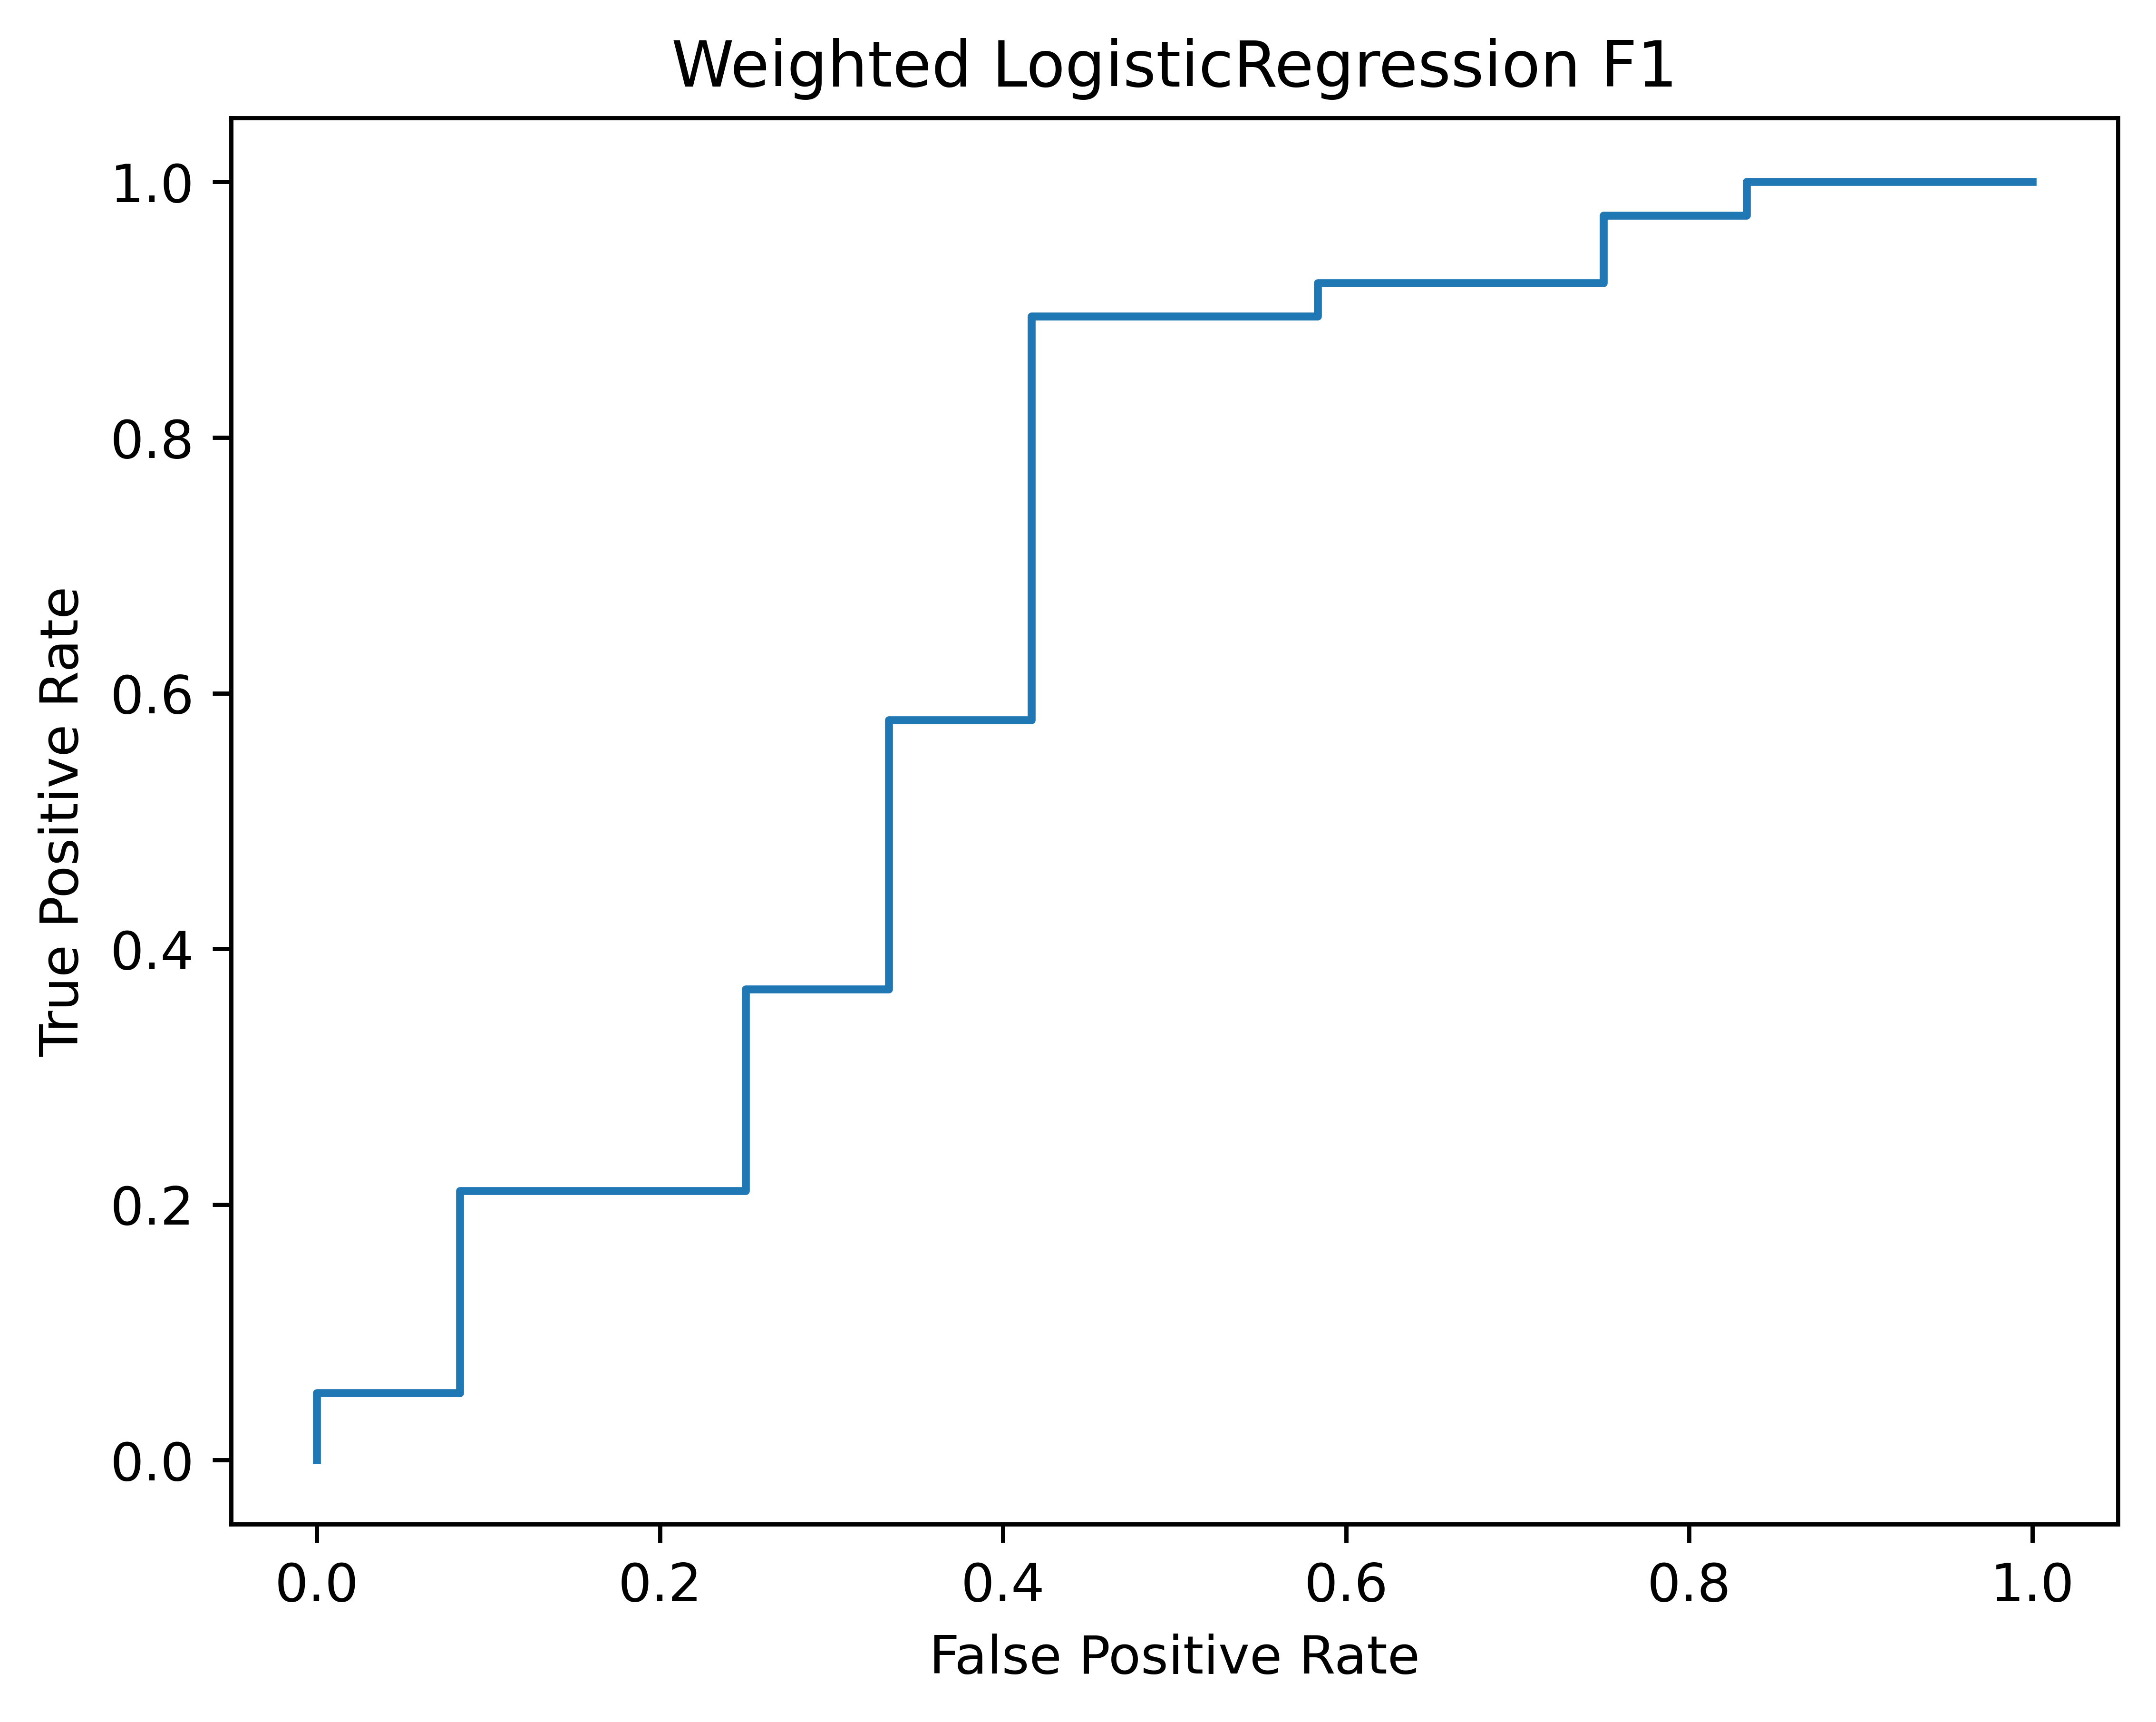


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.934498     0.857143        1.000000      0.806584
1  Fold2       0.946903     0.852459        0.999725      0.539095
2  Fold3       0.949772     0.906250        1.000000      0.627778
3  Fold4       0.951542     0.800000        1.000000      0.726923
4  Fold5       0.960000     0.833333        0.997755      0.650000


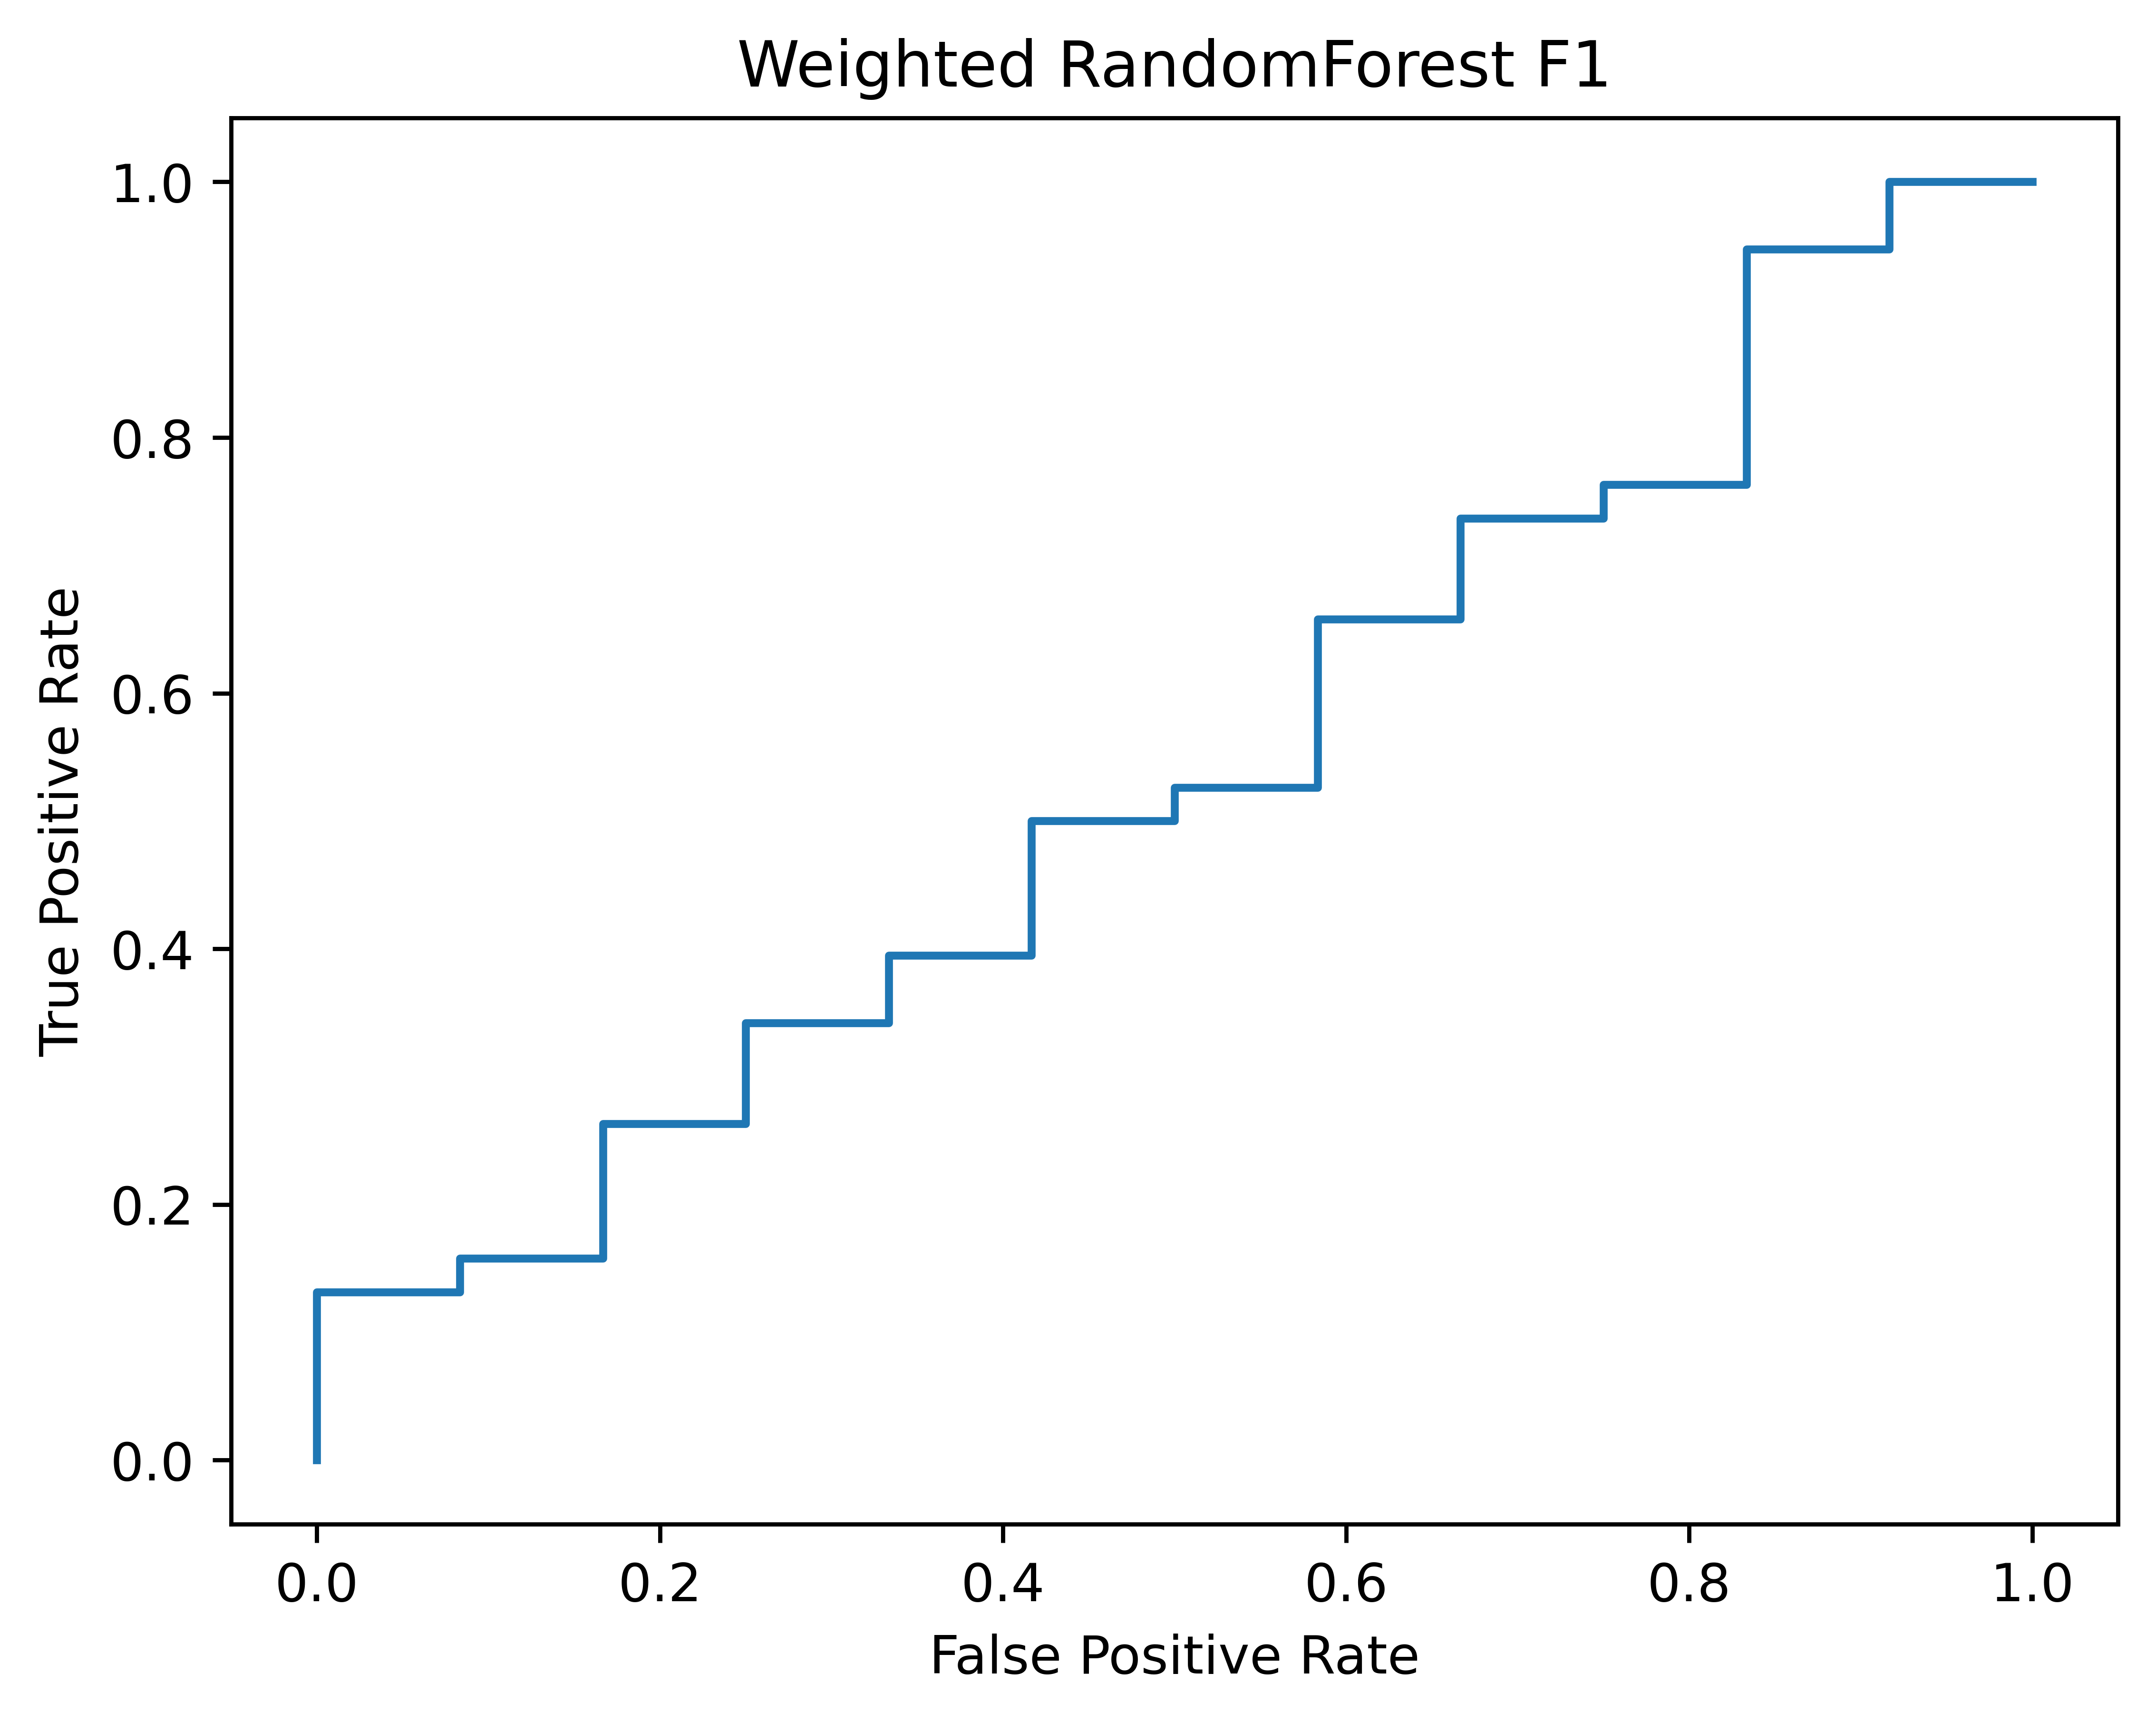


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.885106     0.866667        0.767730      0.641975
1  Fold2       0.899563     0.833333        0.788895      0.481481
2  Fold3       0.880000     0.906250        0.814449      0.472222
3  Fold4       0.898305     0.827586        0.776936      0.700000
4  Fold5       0.862222     0.763636        0.783389      0.615385


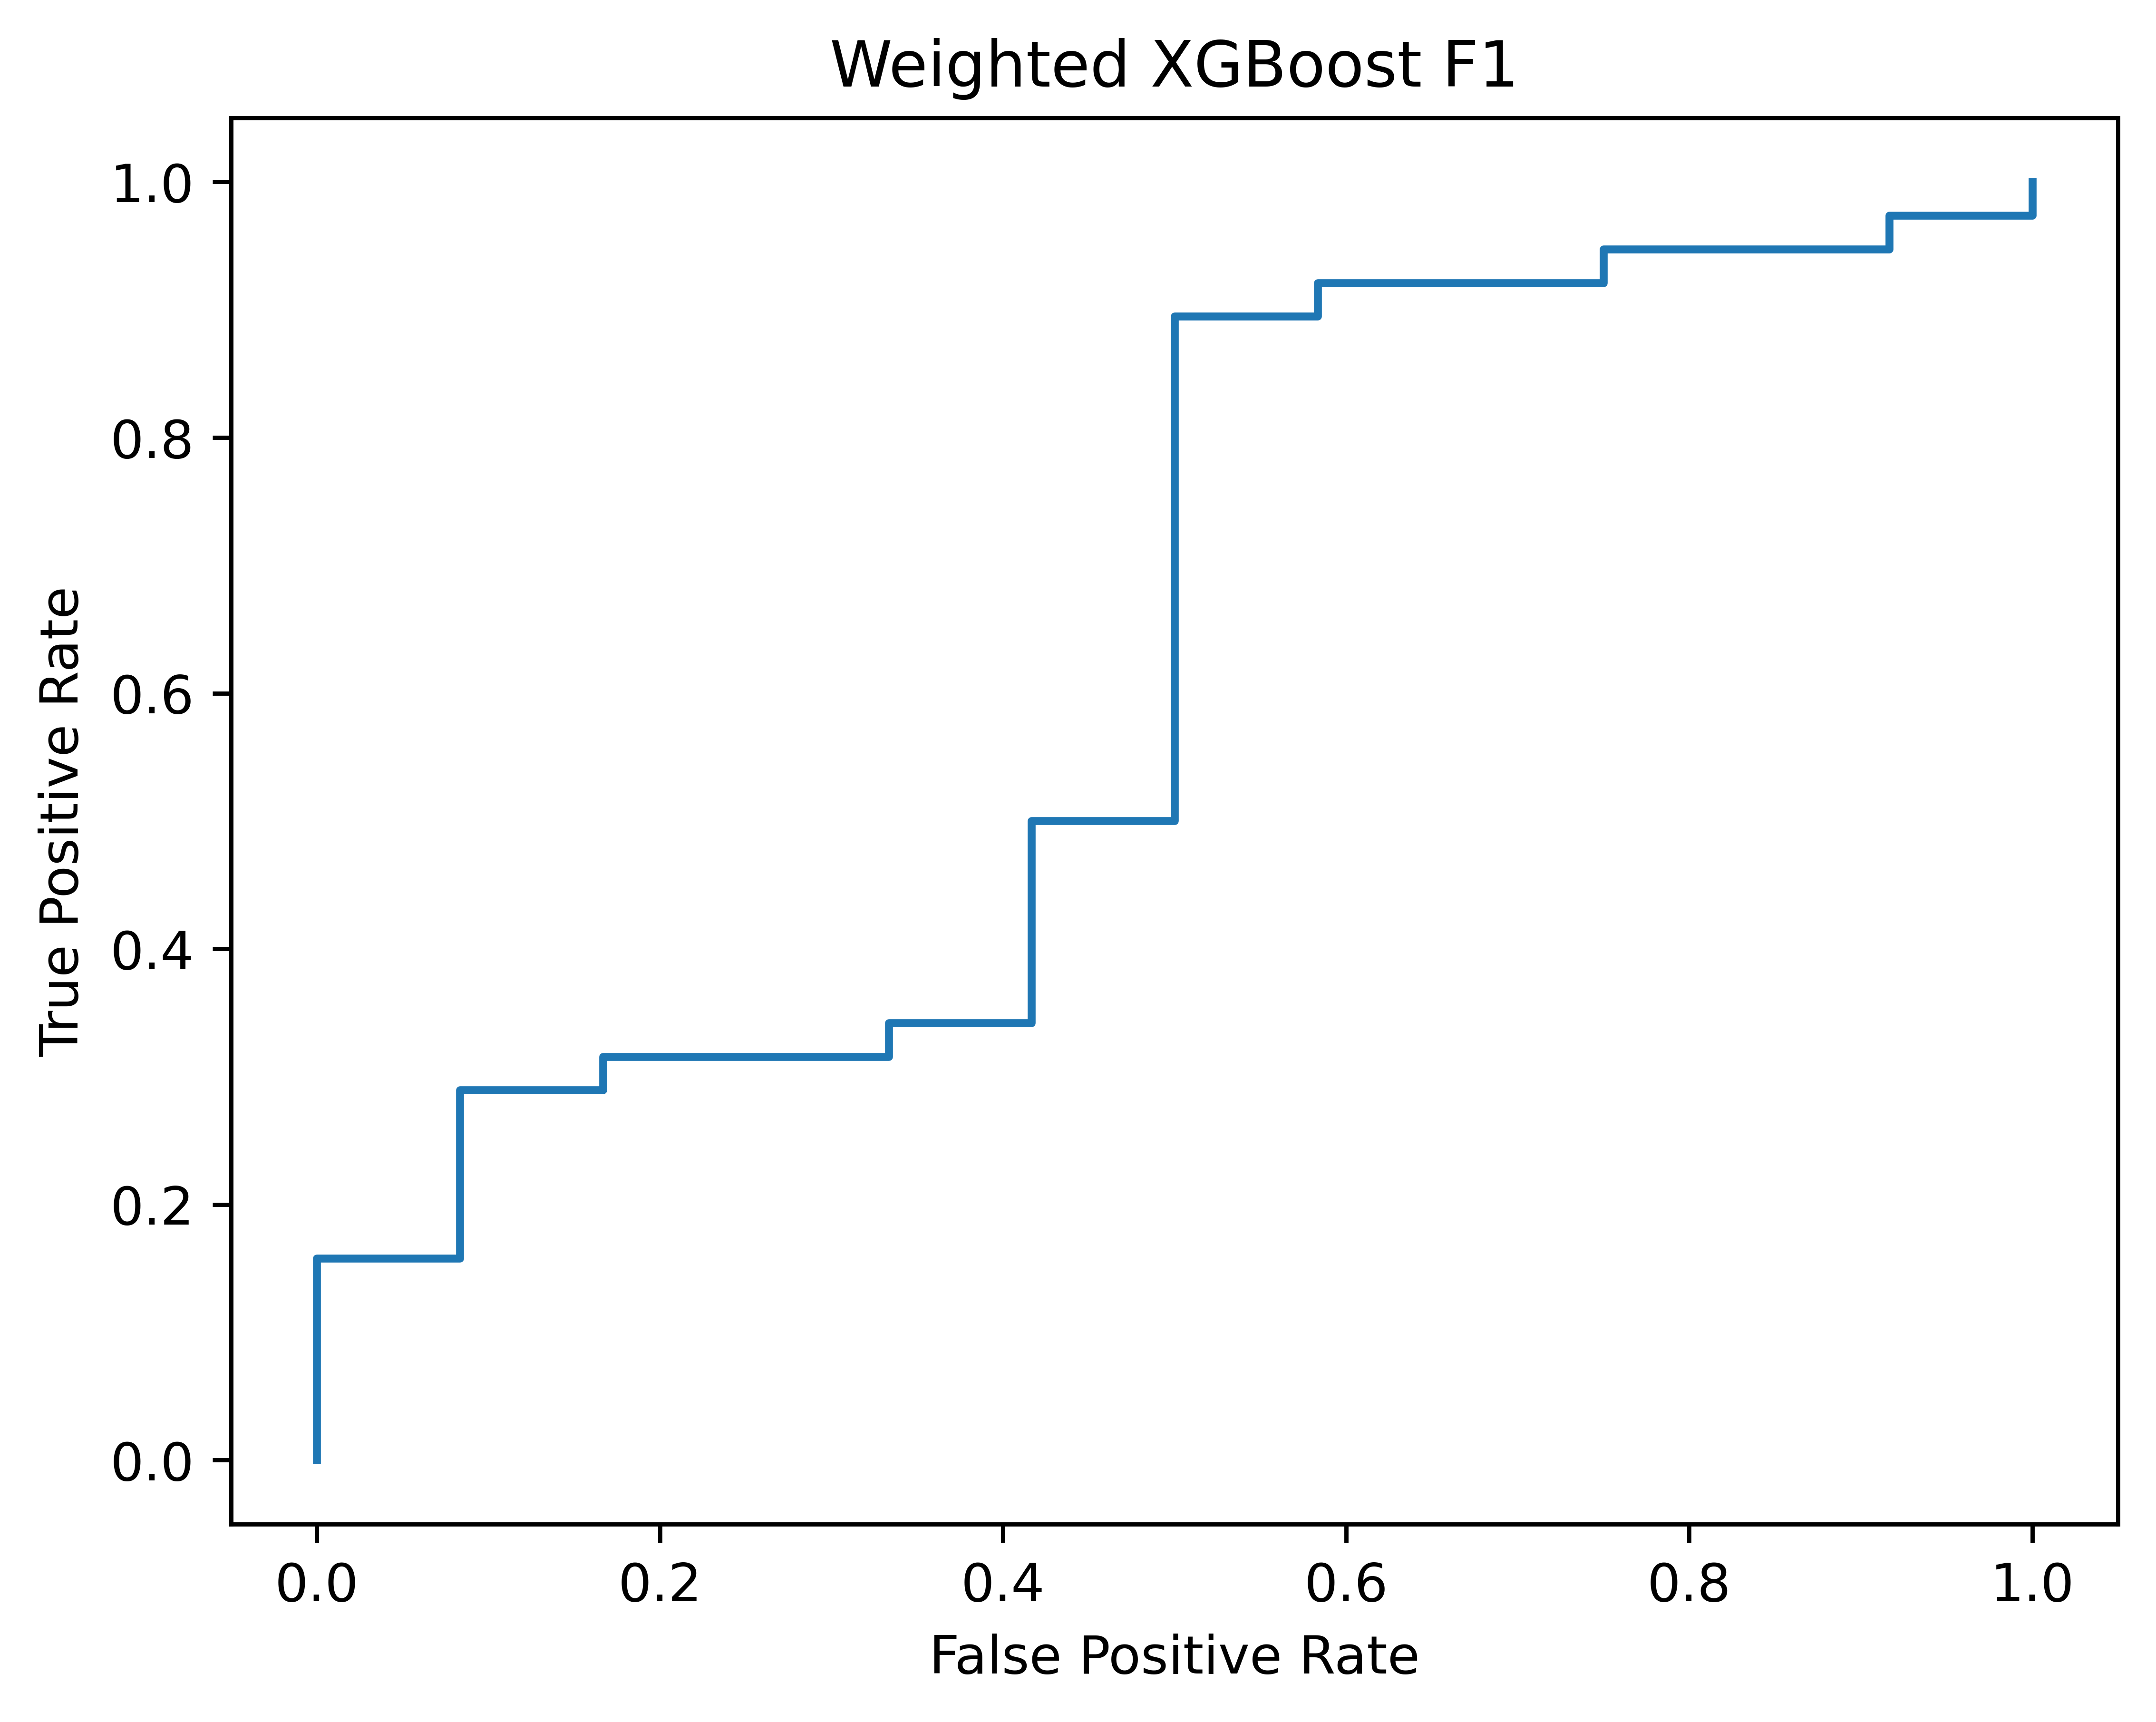


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.633540     0.512821        0.754810      0.572016
1  Fold2       0.733333     0.622222        0.808686      0.563786
2  Fold3       0.702381     0.716981        0.799636      0.450000
3  Fold4       0.562500     0.457143        0.706790      0.650000
4  Fold5       0.566265     0.590909        0.628788      0.550000


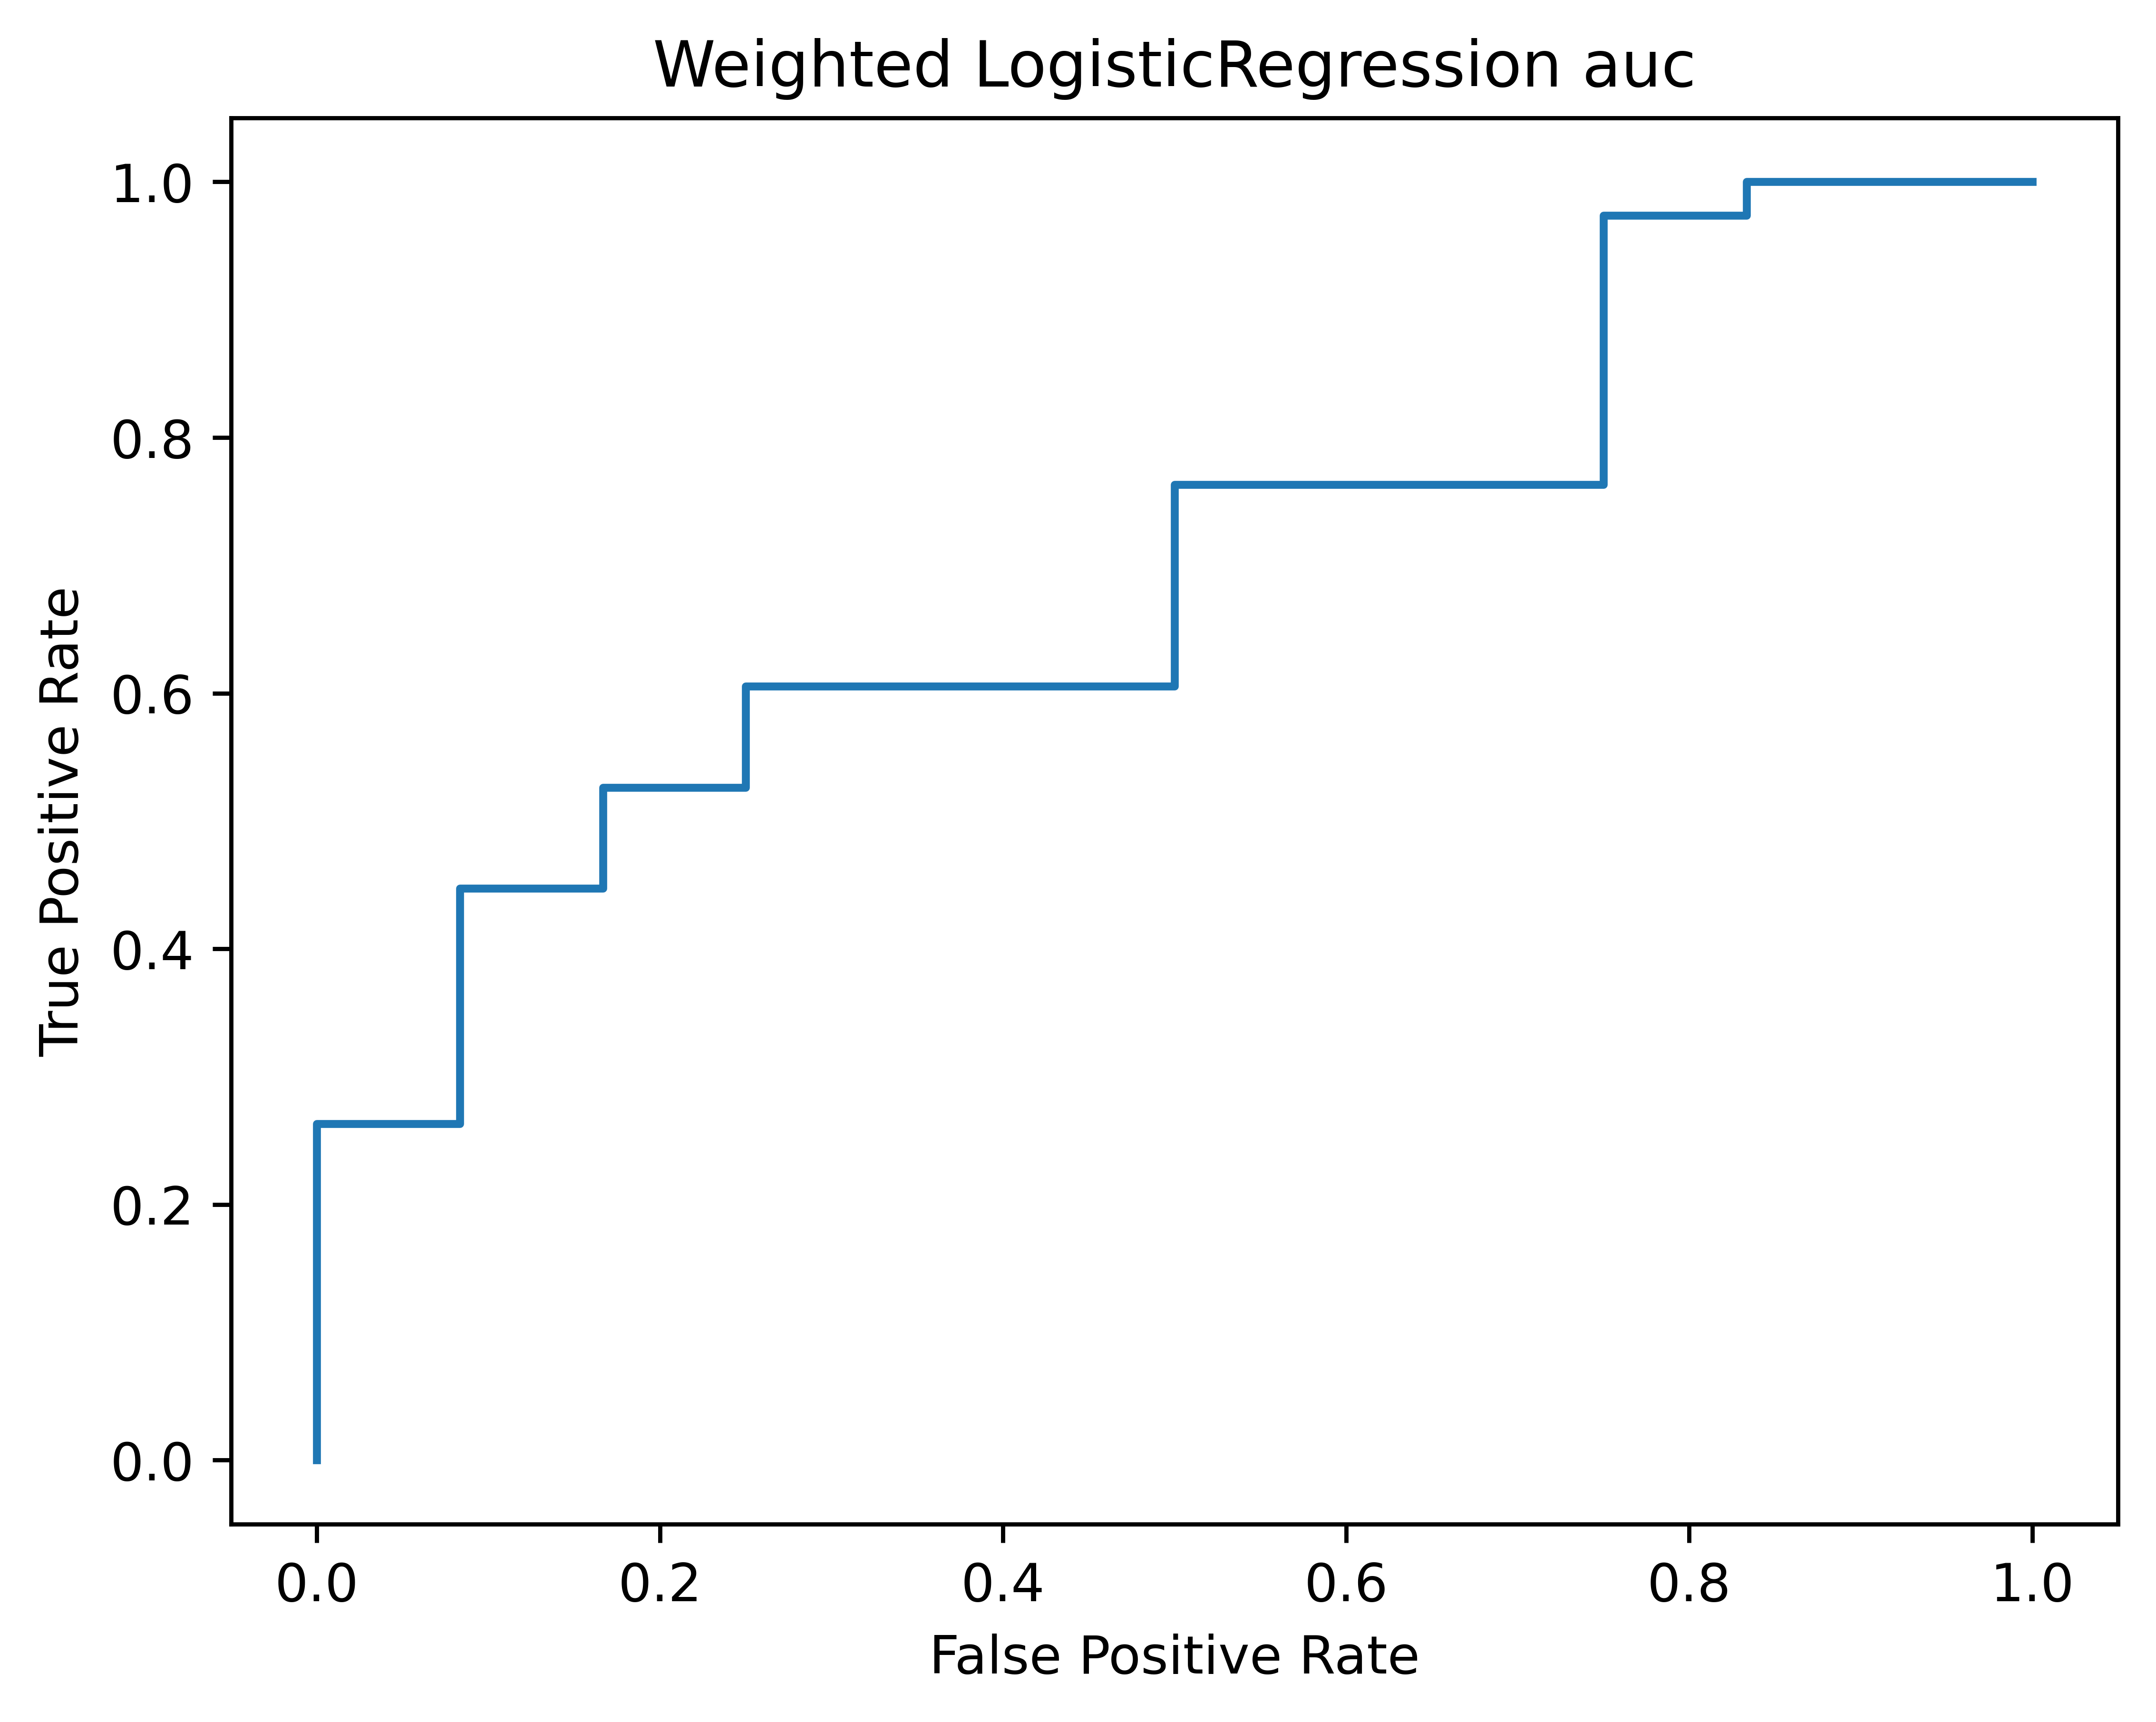


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       1.000000     0.870968        1.000000      0.798354
1  Fold2       0.995305     0.866667        1.000000      0.551440
2  Fold3       0.995169     0.906250        1.000000      0.644444
3  Fold4       0.995349     0.807018        1.000000      0.730769
4  Fold5       0.995349     0.771930        0.999158      0.646154


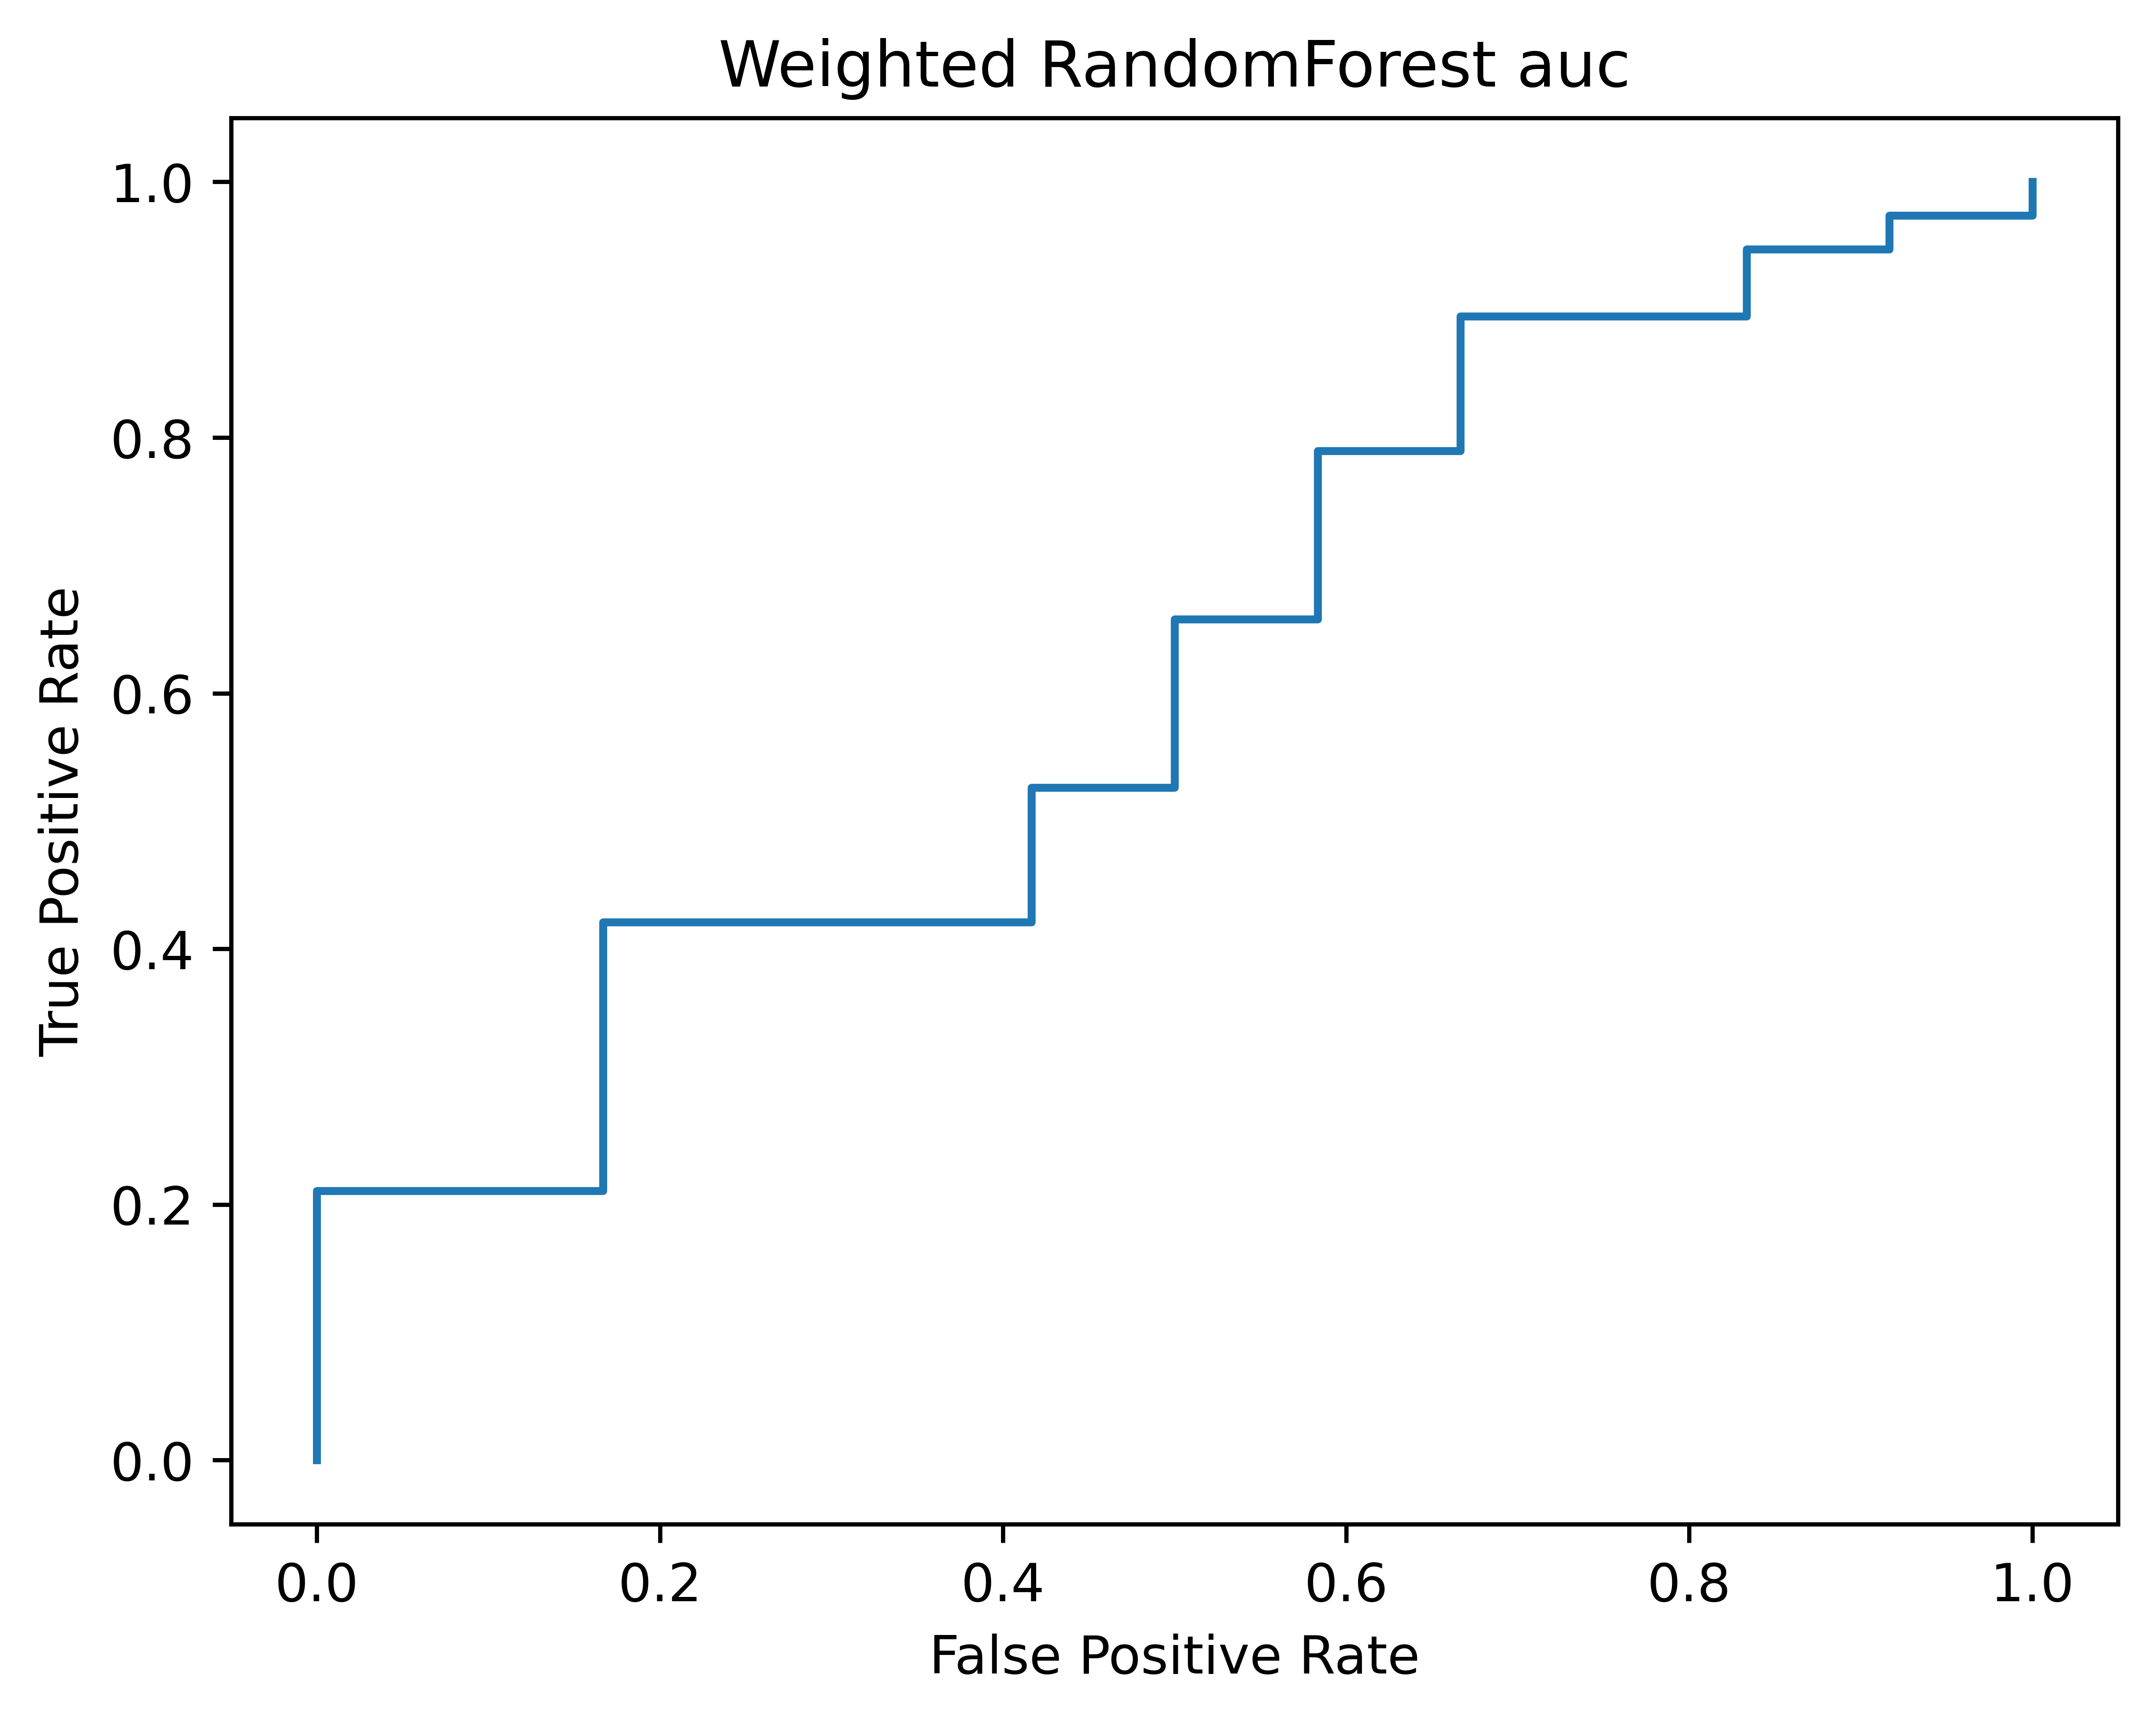


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.378788     0.250000        0.752886      0.670782
1  Fold2       0.390977     0.193548        0.791644      0.539095
2  Fold3       0.424242     0.500000        0.816008      0.483333
3  Fold4       0.338462     0.142857        0.769641      0.707692
4  Fold5       0.338462     0.411765        0.765993      0.550000


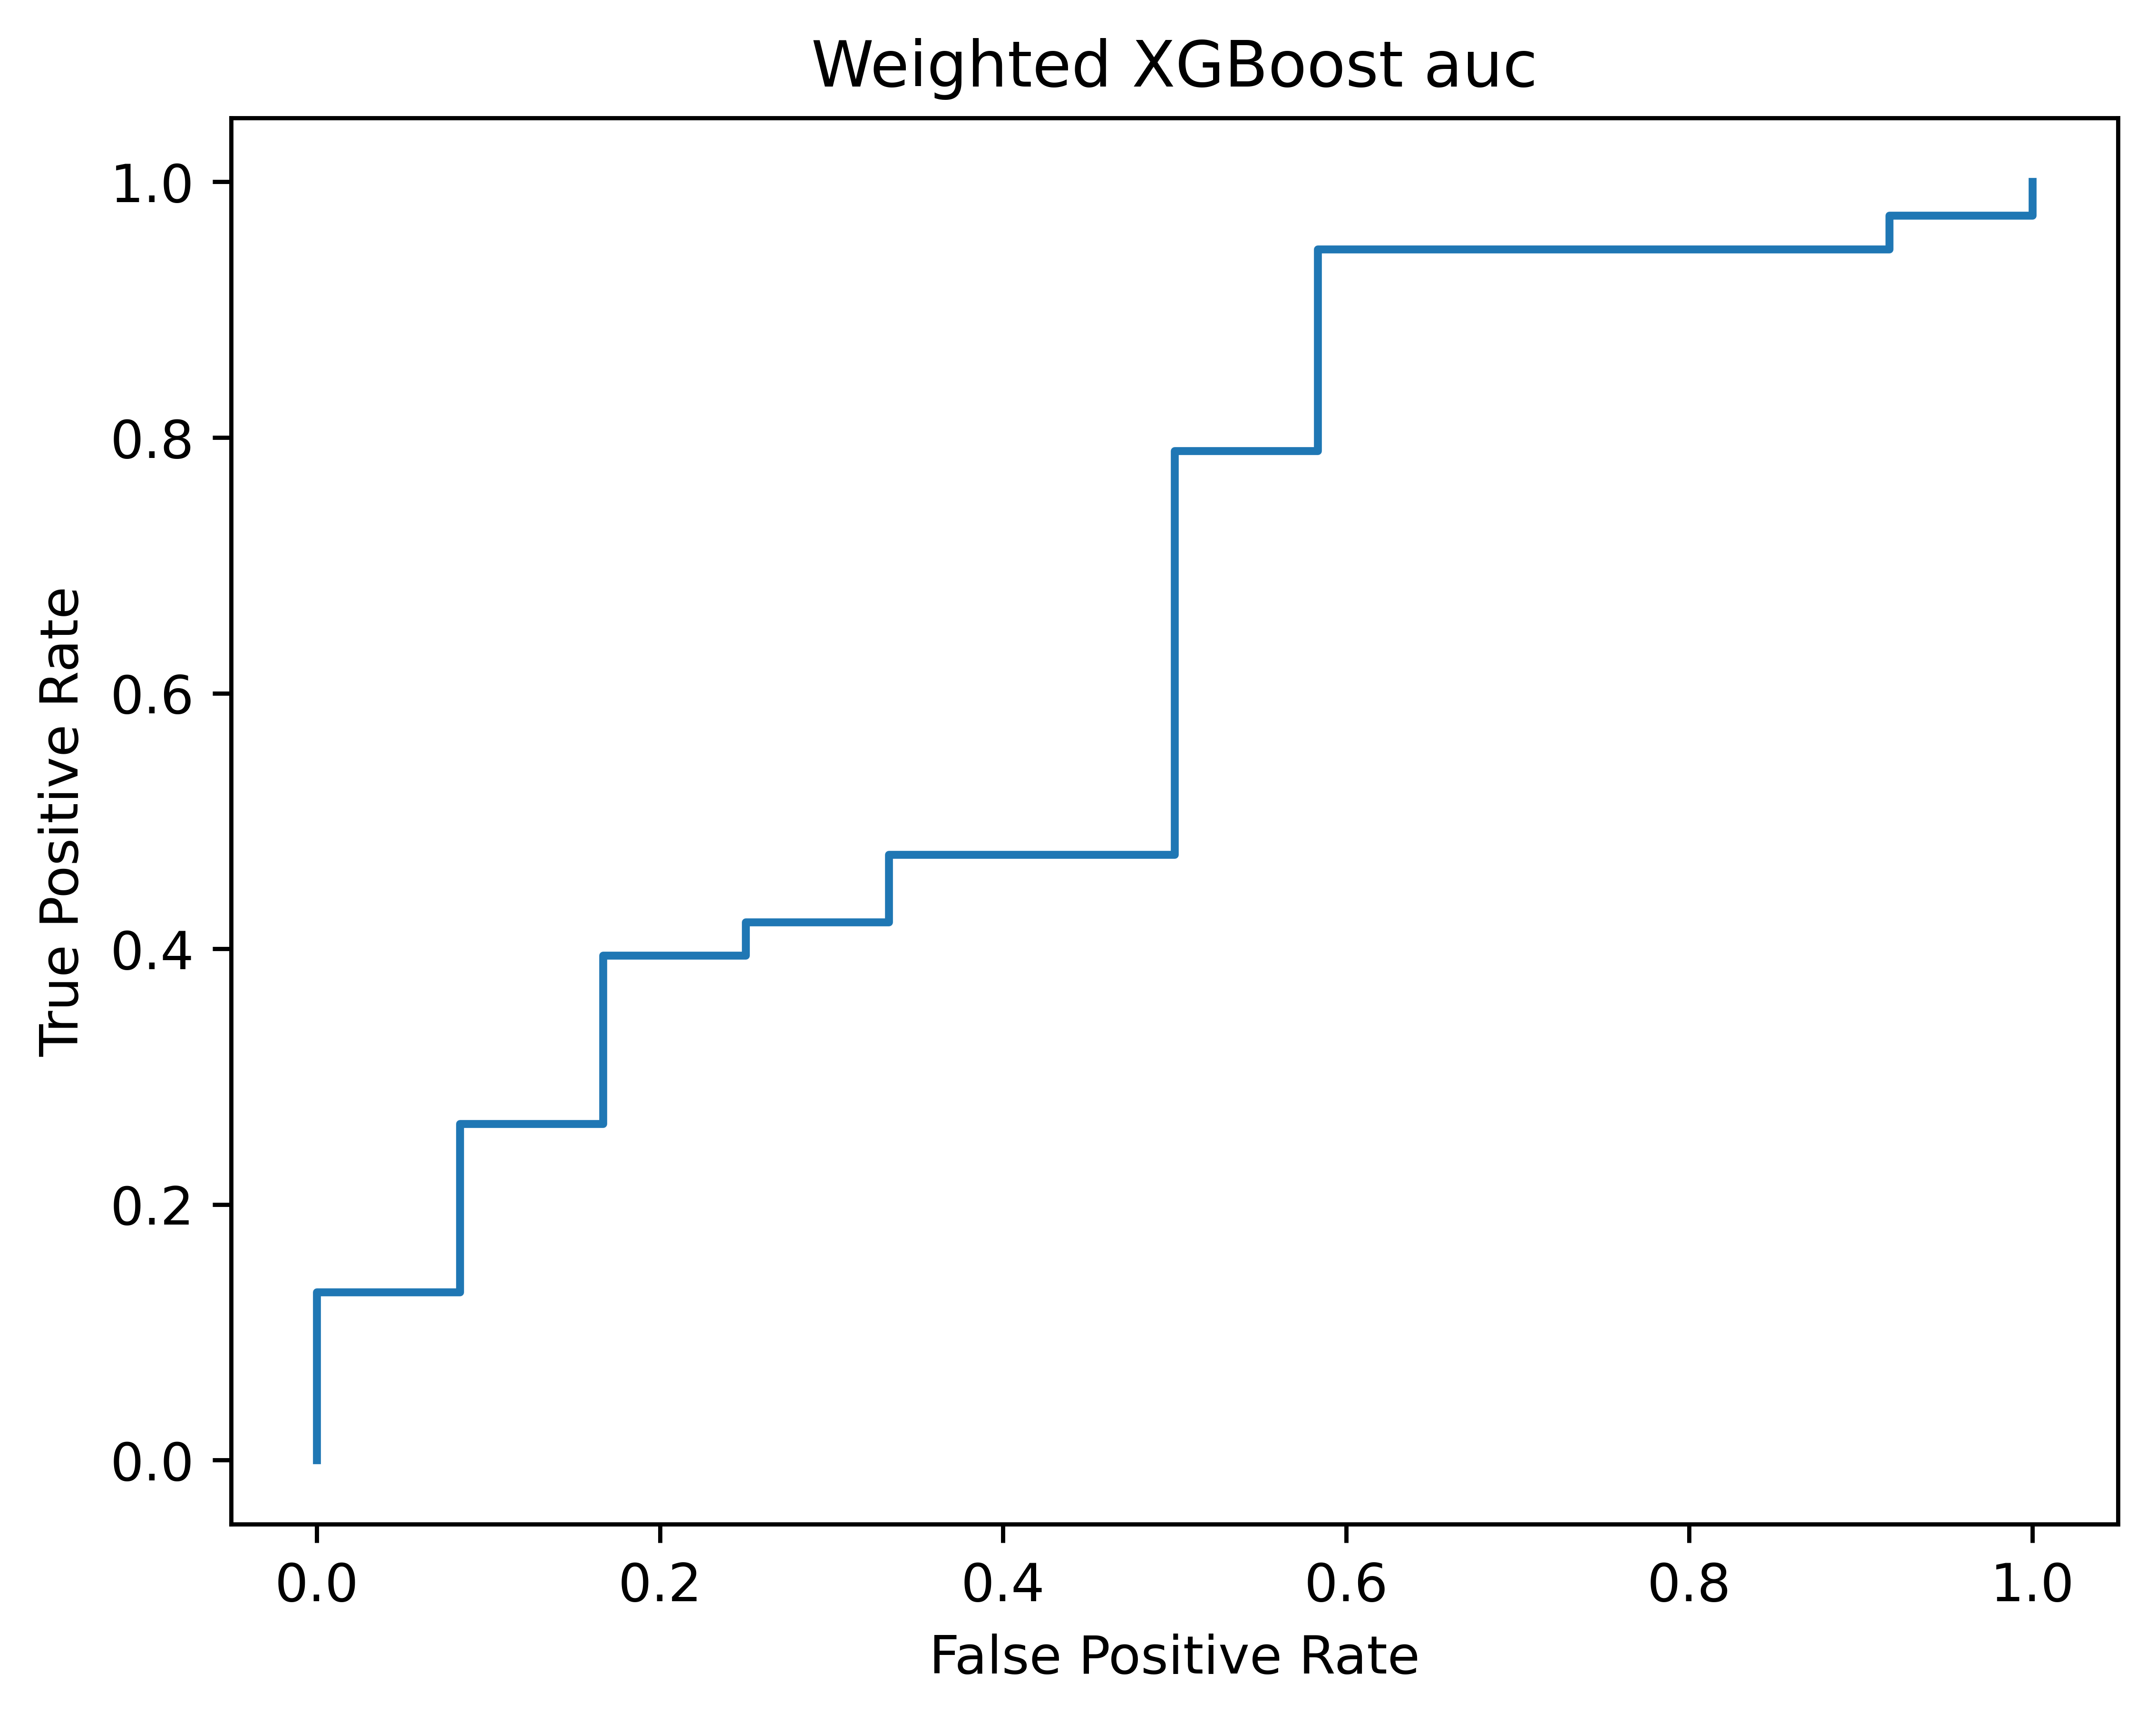


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.733333     0.695652        0.774601      0.621399
1  Fold2       0.759358     0.680851        0.811160      0.551440
2  Fold3       0.765957     0.833333        0.802495      0.438889
3  Fold4       0.655172     0.650000        0.722503      0.653846
4  Fold5       0.787565     0.638298        0.797980      0.434615


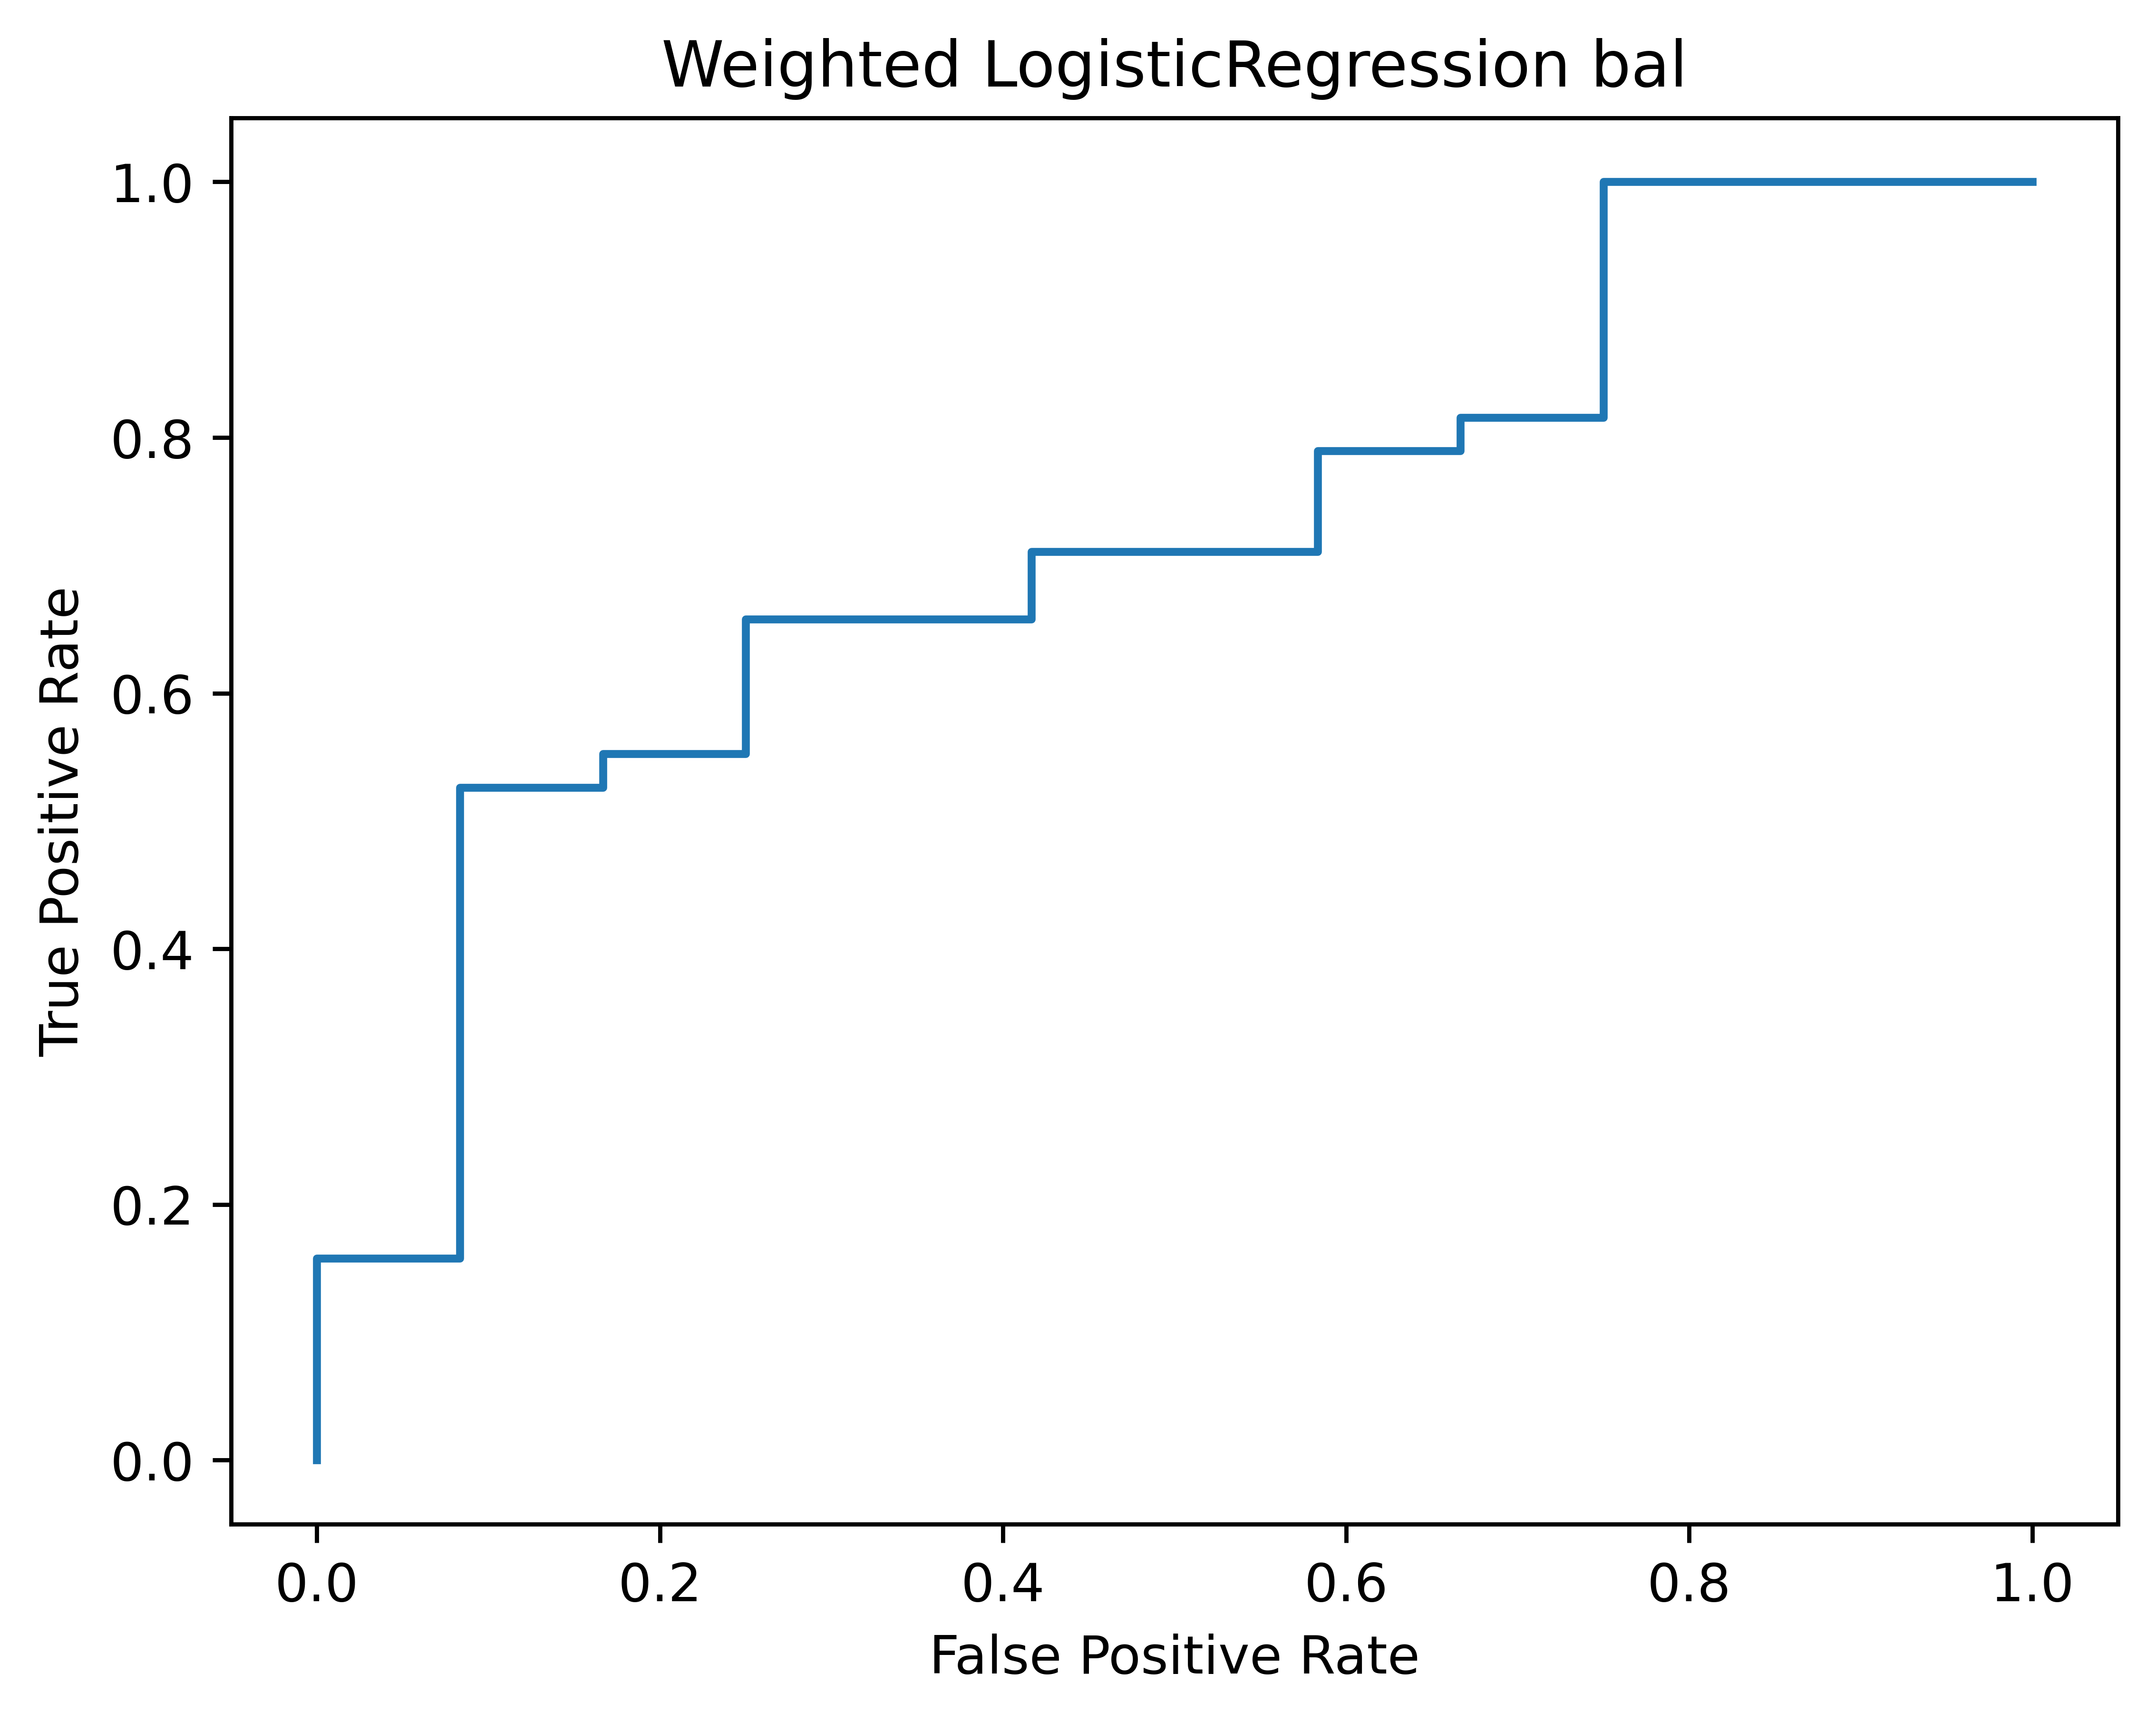


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       1.000000     0.870968        1.000000      0.794239
1  Fold2       1.000000     0.866667        1.000000      0.559671
2  Fold3       0.995169     0.906250        1.000000      0.644444
3  Fold4       0.995349     0.807018        1.000000      0.707692
4  Fold5       0.995349     0.763636        0.998878      0.646154


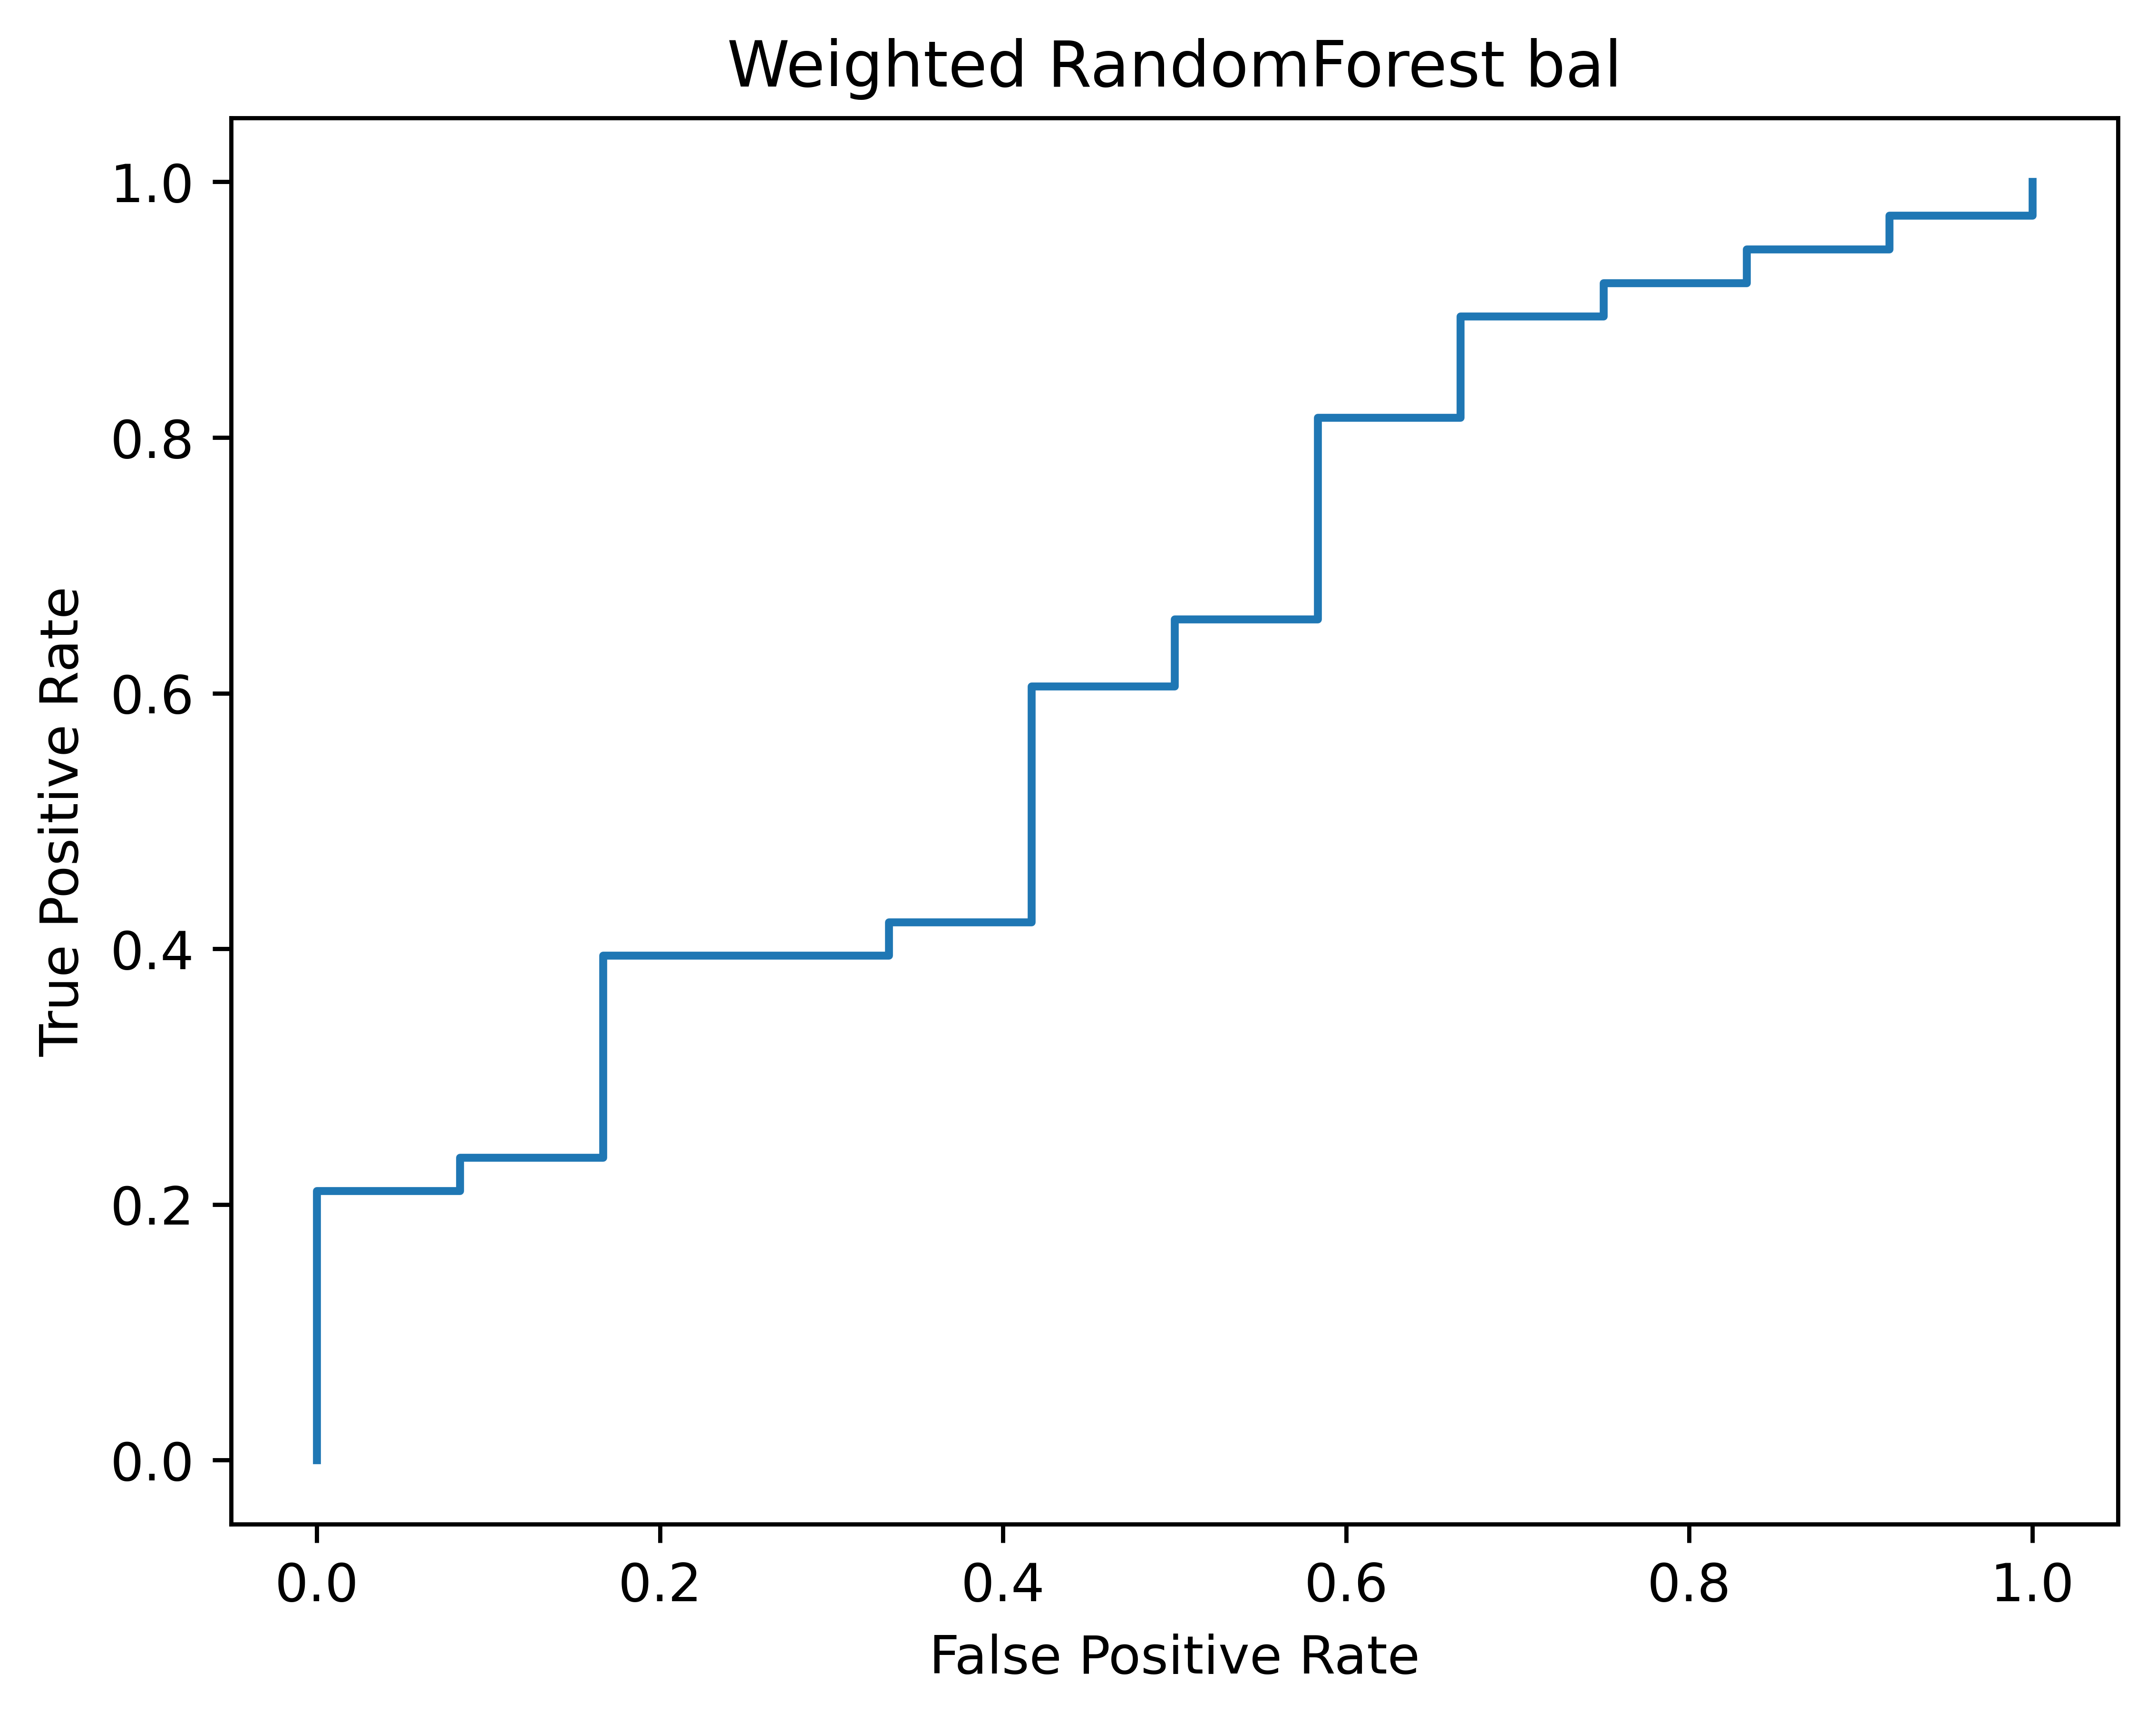


Cross Validation test results saved: 

Cross Validation Training results saved: 
    Fold  Train_F1Score  Val_F1Score  Train_AUCScore  Val_AUCScore
0  Fold1       0.713514     0.666667        0.771028      0.666667
1  Fold2       0.740741     0.680000        0.796592      0.493827
2  Fold3       0.737430     0.793103        0.821985      0.477778
3  Fold4       0.765957     0.760000        0.781706      0.703846
4  Fold5       0.787565     0.680851        0.778339      0.584615


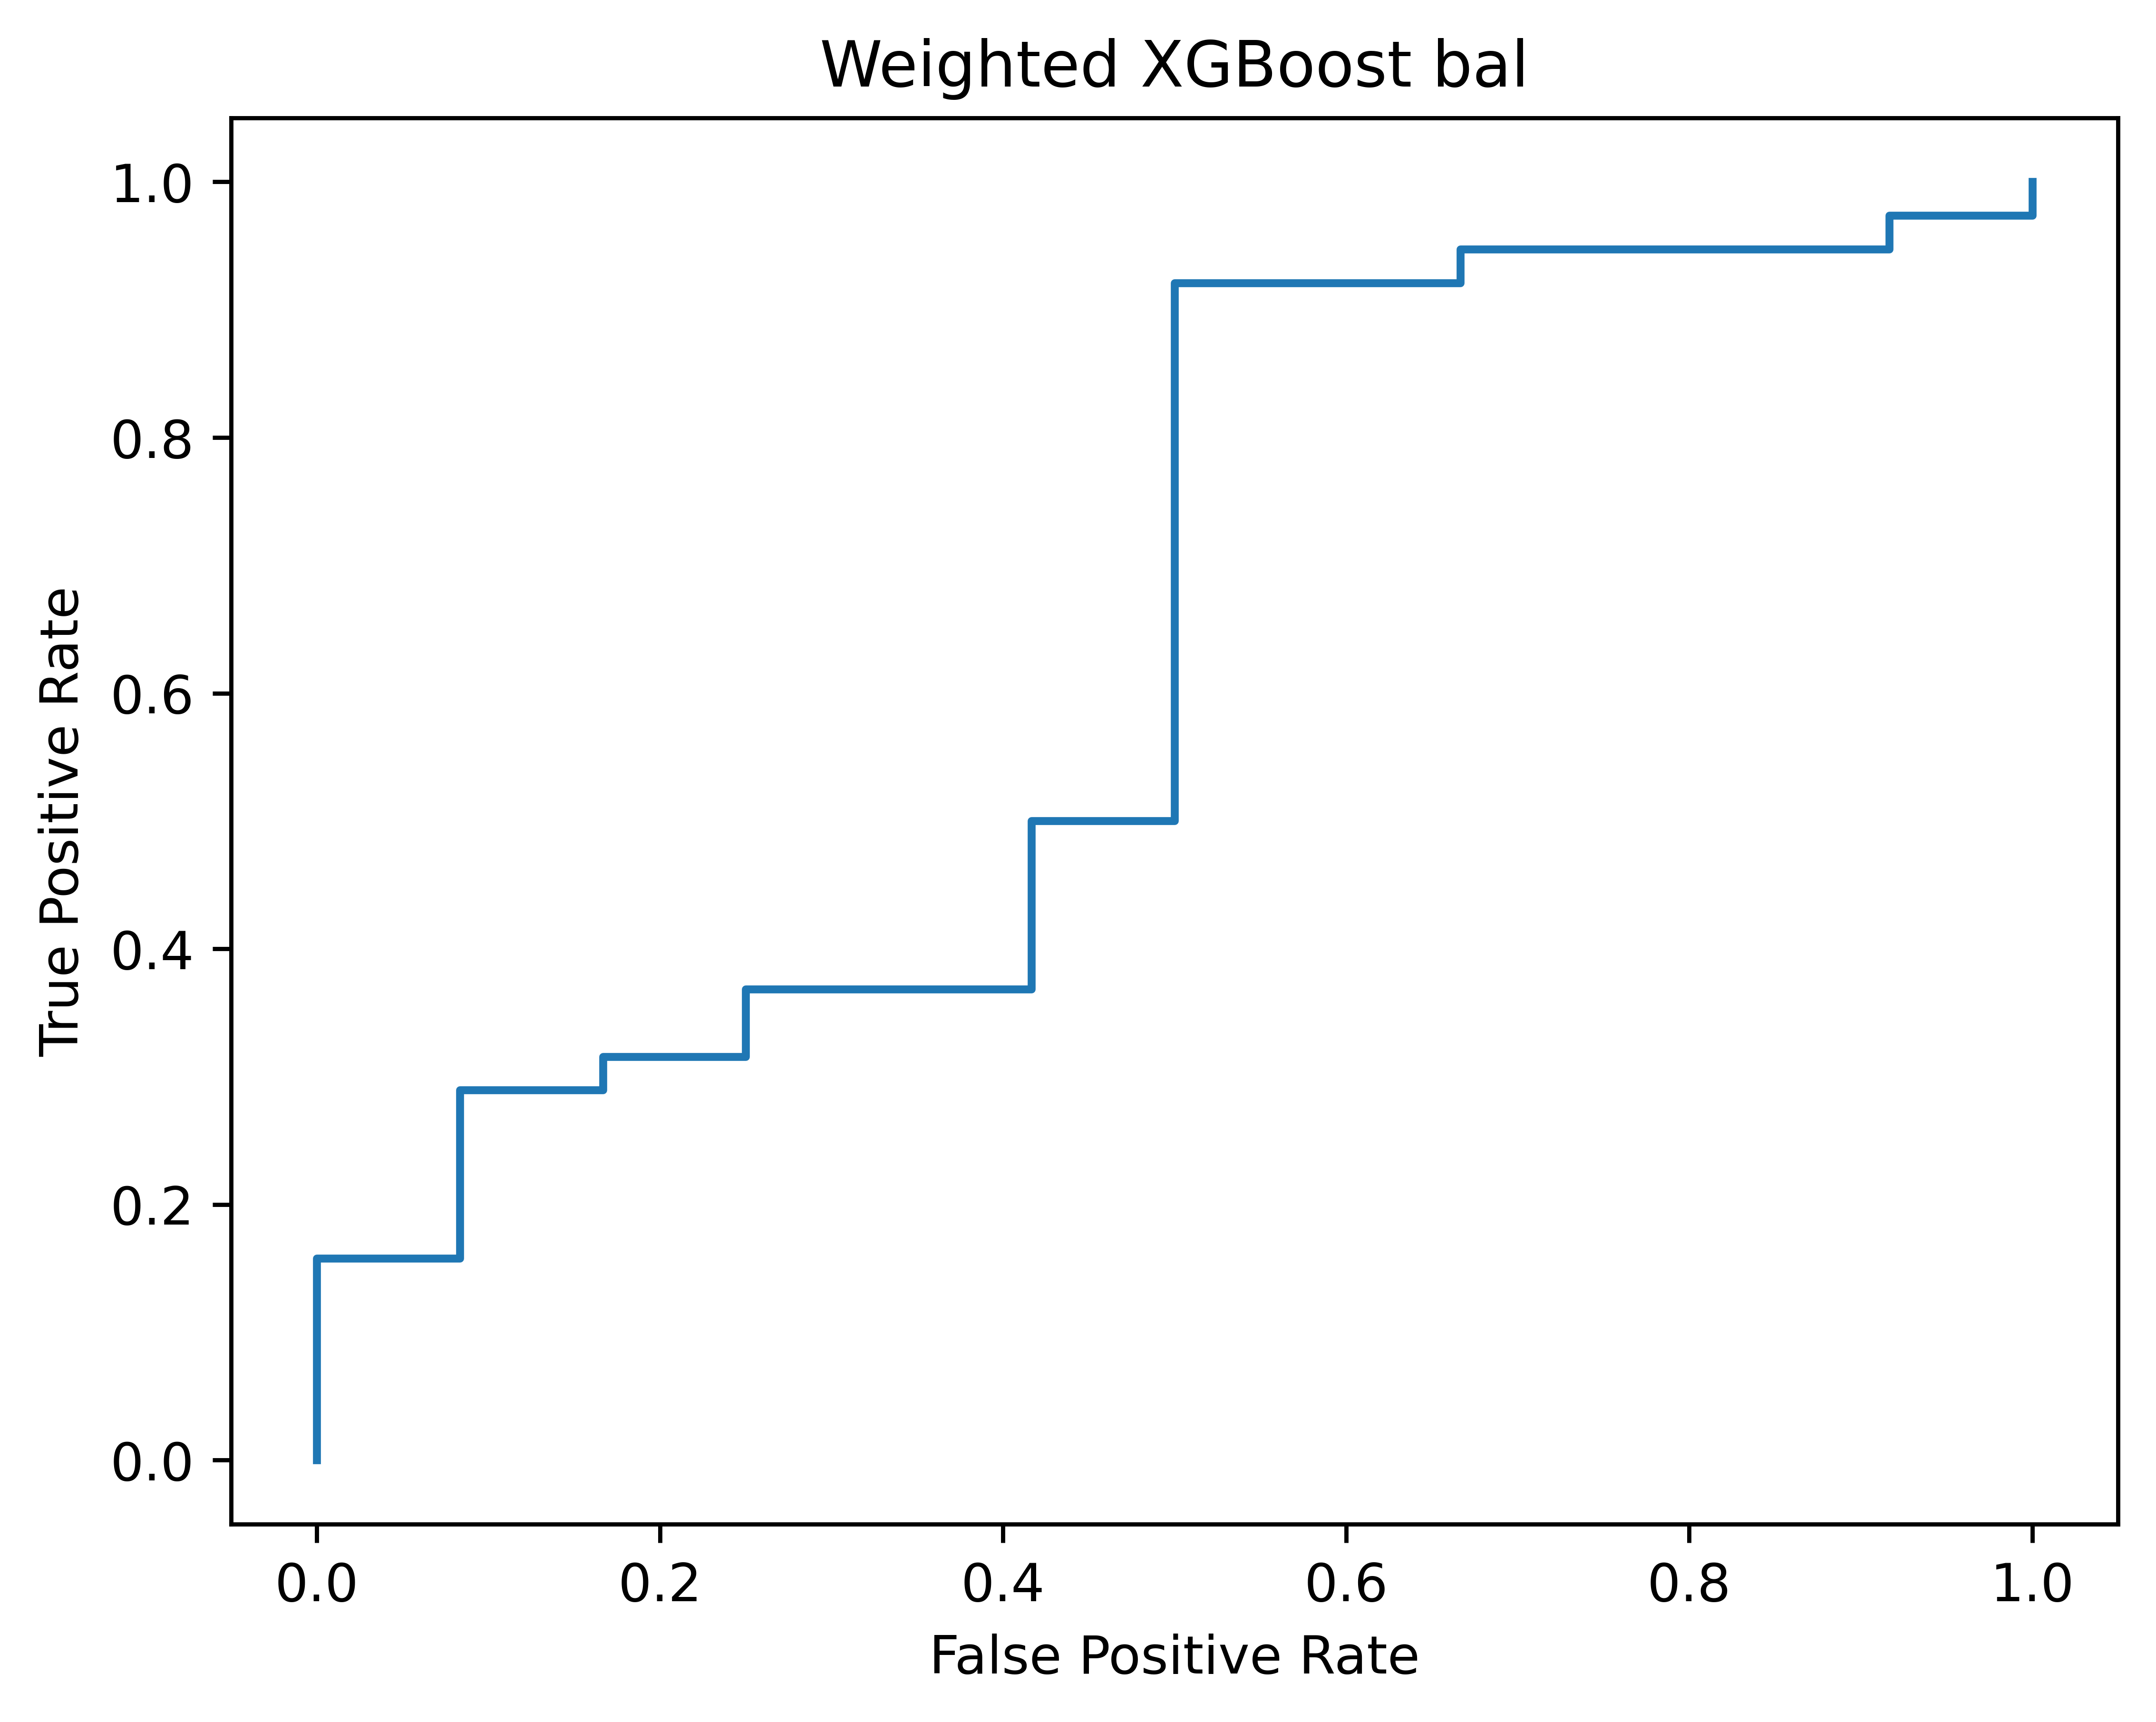


Cross Validation test results saved: 


In [31]:
for main_clf, label in zip([w_log_f1, w_rfc_f1, w_xgb_f1,w_log_auc, w_rfc_auc, w_xgb_auc,w_log_bal, w_rfc_bal, w_xgb_bal], 
                           ["Weighted_LogisticRegression_F1", "Weighted_RandomForest_F1", "Weighted_XGBoost_F1",
                           "Weighted_LogisticRegression_auc", "Weighted_RandomForest_auc", "Weighted_XGBoost_auc",
                           "Weighted_LogisticRegression_bal", "Weighted_RandomForest_bal", "Weighted_XGBoost_bal"]):
    
    #cross validate 
    cv_results = cross_validate(main_clf, X_merge, Y_merge, cv = cv, scoring = ('f1','roc_auc'), return_estimator = True, return_train_score = True)
    my_folds = ["Fold" + str(x) for x in list(range(1,6))]
    train_val_df = pd.DataFrame({"Fold":my_folds, "Train_F1Score":cv_results["train_f1"].tolist(), "Val_F1Score": cv_results["test_f1"].tolist(), "Train_AUCScore":cv_results["train_roc_auc"].tolist(), "Val_AUCScore": cv_results["test_roc_auc"].tolist()})
    train_val_df.to_csv(os.path.join(report_dir, label+"_CVTraining.csv"), index = False)
    print("\nCross Validation Training results saved: ")
    print(train_val_df)
    
    #Get each classifier 
    clf1 = cv_results["estimator"][0]
    clf2 = cv_results["estimator"][1]
    clf3 = cv_results["estimator"][2]
    clf4 = cv_results["estimator"][3]
    clf5 = cv_results["estimator"][4]

    #get ensemble methods
    hard_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='hard')
    hard_vote_ens.fit(X_merge, Y_merge)
    soft_vote_ens = VotingClassifier(estimators=[("m1", clf1), ("m2", clf2), ("m3",clf3), ("m4", clf4), ("m5",clf5)], voting='soft')
    soft_vote_ens.fit(X_merge, Y_merge)

    #Get metrics
    test_metrics_dict = {"Model":[], "Accuracy":[], "PPV":[], "Sensitivity":[], "NPV":[], "Specificity":[], "FPR":[], "F1_Score":[], "ConfusionMatrix":[], 
                     "YPred_Prob":[], "AUC":[], "ROC_TPR":[], "ROC_FPR":[], "ROC_Threshold":[]}


    for clf, model in zip([clf1, clf2, clf3, clf4, clf5, hard_vote_ens, soft_vote_ens], ["Fold1", "Fold2", "Fold3", "Fold4", "Fold5", "HardVote_Ensemble", "SoftVote_Ensemble"]):
        ypred = clf.predict(X_test)

        #calculate metrics  
        acc = accuracy_score(Y_test, ypred)
        ppv = precision_score(Y_test, ypred)
        CM = confusion_matrix(Y_test, ypred)
        f1 = f1_score(Y_test, ypred)
        sens = recall_score(Y_test, ypred)
        tn, fp, fn, tp = confusion_matrix(Y_test, ypred).ravel()
        spec = tn / (tn+fp)
        FPR = fp/(fp+tn)
        npv = tn/(tn+fn)

        #append
        test_metrics_dict["Model"].append(model)
        test_metrics_dict["Accuracy"].append(acc)
        test_metrics_dict["PPV"].append(ppv)
        test_metrics_dict["Sensitivity"].append(sens)
        test_metrics_dict["Specificity"].append(spec)
        test_metrics_dict["FPR"].append(FPR)
        test_metrics_dict["F1_Score"].append(f1)
        test_metrics_dict["ConfusionMatrix"].append(CM)
        test_metrics_dict["NPV"].append(npv)
        
        #ROC AUC analysis
        if "HardVote" not in model: 
            ypred_prob = clf.predict_proba(X_test)[:,1]
            auc = roc_auc_score(Y_test, ypred_prob)
            roc_fpr, roc_tpr, thresholds = roc_curve(Y_test, ypred_prob)
        else: 
            ypred_prob = np.nan
            auc = np.nan
            roc_fpr = roc_tpr = thresholds = np.nan

        #append AUC ROC metrics 
        test_metrics_dict["AUC"].append(auc)
        test_metrics_dict["YPred_Prob"].append(ypred_prob)
        test_metrics_dict["ROC_TPR"].append(roc_tpr)
        test_metrics_dict["ROC_FPR"].append(roc_fpr)
        test_metrics_dict["ROC_Threshold"].append(thresholds)

        #plot ROC
        if "SoftVote" in model: 
            plt.plot(roc_fpr, roc_tpr)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(label.replace("_", " "))
            plt.show()

        #prediction dictionary for bootstrap statistical analysis later
        bootstrap_metrics_dict = {"File":[], "unique_scandate":[], "unique_pt":[], "gt":[], "pred_bin":[], "pred_contin":[]}
        for _i in range(0,len(ypred)):
            bootstrap_metrics_dict["File"].append(Y_files[_i])
            bootstrap_metrics_dict["unique_scandate"].append(Y_scans[_i])
            bootstrap_metrics_dict["unique_pt"].append(Y_pts[_i])
            bootstrap_metrics_dict["gt"].append(Y_test.tolist()[_i])
            bootstrap_metrics_dict["pred_bin"].append(ypred[_i])
            if "HardVote" not in model:
                bootstrap_metrics_dict["pred_contin"].append(ypred_prob[_i])
            else:
                bootstrap_metrics_dict["pred_contin"].append(np.nan)
        b_df = pd.DataFrame(bootstrap_metrics_dict)
        b_df.to_csv(os.path.join(report_dir, label+"_"+model+"_predictions_test.csv"), index = False)
    
    #Save results    
    df = pd.DataFrame(test_metrics_dict)
    print(("\nCross Validation test results saved: "))
    df.to_csv(os.path.join(report_dir, label+"_CVresults.csv"), index = False)


# STOP

In [28]:
#Best model move the Operating point 